# Machine-Aided Self-diagnostic Prediction Models for Polycystic Ovary Syndrome (PCOS)

## 📋 Overview

This notebook implements the complete machine learning pipeline from the observational study on PCOS prediction. Polycystic Ovary Syndrome (PCOS) is one of the most common endocrine disorders affecting women of reproductive age, impacting 5-20% of women globally.

## 🎯 Objectives

1. **Develop two distinct prediction models:**
   - **Patient Model**: Uses only non-invasive features accessible to patients (anthropomorphic measurements, symptoms, and given information)
   - **Provider Model**: Uses all features including clinical test results for healthcare provider decision support

2. **Implement unsupervised clustering** to identify patient subgroups with distinct PCOS characteristics

3. **Build subgroup-specific models** to improve prediction accuracy for heterogeneous populations

4. **Provide interpretability** through SHAP (SHapley Additive exPlanations) analysis

## 📊 Dataset

The study uses clinical data from 541 patients collected at hospitals in Kerala, India, containing:
- Anthropomorphic measurements (BMI, height, weight, hip/waist measurements)
- Clinical symptoms (skin darkening, hair growth/loss, irregular cycles)
- Lifestyle factors (diet, exercise)
- Hormonal and metabolic test results

## 🔬 Methodology

1. **Feature Categorization**: Organize features into anthropomorphic, symptom, given, and test result categories
2. **Dimensionality Reduction**: Apply PCA to anthropomorphic variables
3. **Clustering**: Use K-means (k=2) on principal components to identify subgroups
4. **Model Training**: Train CatBoost classifiers with nested cross-validation
5. **Interpretability**: Analyze feature importance using SHAP values

---

## 1. Library Imports

Import all necessary libraries for data processing, visualization, machine learning, and interpretability analysis.

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Machine learning - preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Machine learning - model selection and evaluation
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc
)

# CatBoost classifier
from catboost import CatBoostClassifier

# SHAP for model interpretability
import shap

# Statistical analysis
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency

# System utilities
import os
from collections import defaultdict

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("✅ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

✅ All libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 2.0.2
Matplotlib version: 3.10.0
Seaborn version: 0.13.2


## 2. Data Loading

Load the PCOS dataset from two sources:
1. `PCOS_data_without_infertility.xlsx` - Main dataset with full clinical features
2. `PCOS_infertility.csv` - Supplementary infertility-related data

In [2]:
# Load main dataset from Excel file
df_main = pd.read_excel('/kaggle/input/polycystic-ovary-syndrome-pcos/PCOS_data_without_infertility.xlsx', sheet_name='Full_new')
print(f"Main dataset shape: {df_main.shape}")
print(f"\nColumns: {df_main.shape[1]}")
print(f"Rows: {df_main.shape[0]}")

# Load infertility dataset from CSV
df_infertility = pd.read_csv('/kaggle/input/polycystic-ovary-syndrome-pcos/PCOS_infertility.csv')
print(f"\nInfertility dataset shape: {df_infertility.shape}")

# Display first few rows
print("\n" + "="*80)
print("First 5 rows of main dataset:")
print("="*80)
df_main.head()

Main dataset shape: (541, 45)

Columns: 45
Rows: 541

Infertility dataset shape: (541, 6)

First 5 rows of main dataset:


,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm),Unnamed: 44
0,1,1,0,28,44.6,152.0,19.300000,15,78,22,...,1.0,0,110,80,3,3,18.0,18.0,8.5,NaN
1,2,2,0,36,65.0,161.5,24.921163,15,74,20,...,0.0,0,120,70,3,5,15.0,14.0,3.7,NaN
2,3,3,1,33,68.8,165.0,25.270891,11,72,18,...,1.0,0,120,80,13,15,18.0,20.0,10.0,NaN
3,4,4,0,37,65.0,148.0,29.674945,13,72,20,...,0.0,0,120,70,2,2,15.0,14.0,7.5,NaN
4,5,5,0,25,52.0,161.0,20.060954,11,72,18,...,0.0,0,120,80,3,4,16.0,14.0,7.0,NaN


In [3]:
# Check data types and missing values
print("Data Info:")
print("="*80)
df_main.info()

print("\n" + "="*80)
print("Missing Values Summary:")
print("="*80)
missing_summary = pd.DataFrame({
    'Column': df_main.columns,
    'Missing_Count': df_main.isnull().sum().values,
    'Missing_Percentage': (df_main.isnull().sum().values / len(df_main) * 100).round(2)
})
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print(missing_summary.to_string(index=False))

# Check target variable distribution
print("\n" + "="*80)
print("Target Variable Distribution (PCOS):")
print("="*80)
target_dist = df_main['PCOS (Y/N)'].value_counts()
print(f"PCOS Negative (0): {target_dist[0]} ({target_dist[0]/len(df_main)*100:.2f}%)")
print(f"PCOS Positive (1): {target_dist[1]} ({target_dist[1]/len(df_main)*100:.2f}%)")

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   PCOS (Y/N)              541 non-null    int64  
 3    Age (yrs)              541 non-null    int64  
 4   Weight (Kg)             541 non-null    float64
 5   Height(Cm)              541 non-null    float64
 6   BMI                     541 non-null    float64
 7   Blood Group             541 non-null    int64  
 8   Pulse rate(bpm)         541 non-null    int64  
 9   RR (breaths/min)        541 non-null    int64  
 10  Hb(g/dl)                541 non-null    float64
 11  Cycle(R/I)              541 non-null    int64  
 12  Cycle length(days)      541 non-null    int64  
 13  Marraige Status (Yrs)   540 non-null    float64
 14  Pregnant(Y/N)           541 non

## 3. Exploratory Data Analysis (EDA)

Comprehensive analysis comparing PCOS-positive vs PCOS-negative groups across various clinical and demographic features.

In [4]:
# Create a working copy of the dataset
df = df_main.copy()

# Drop unnecessary columns
df = df.drop(['Sl. No', 'Patient File No.', 'Unnamed: 44'], axis=1, errors='ignore')

# Separate PCOS positive and negative groups
pcos_positive = df[df['PCOS (Y/N)'] == 1]
pcos_negative = df[df['PCOS (Y/N)'] == 0]

print(f"PCOS Positive cases: {len(pcos_positive)}")
print(f"PCOS Negative cases: {len(pcos_negative)}")

PCOS Positive cases: 177
PCOS Negative cases: 364


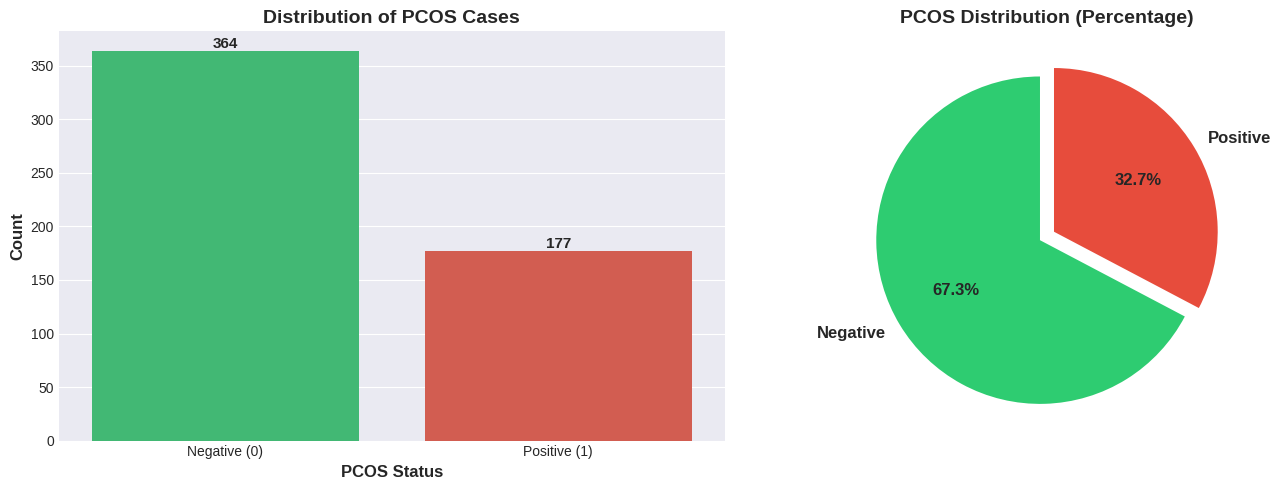

In [5]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df, x='PCOS (Y/N)', ax=axes[0], palette=['#2ecc71', '#e74c3c'])
axes[0].set_xlabel('PCOS Status', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of PCOS Cases', fontsize=14, fontweight='bold')
axes[0].set_xticklabels(['Negative (0)', 'Positive (1)'])

# Add count labels
for container in axes[0].containers:
    axes[0].bar_label(container, fontsize=11, fontweight='bold')

# Pie chart
colors = ['#2ecc71', '#e74c3c']
explode = (0.05, 0.05)
target_counts = df['PCOS (Y/N)'].value_counts()
axes[1].pie(target_counts, labels=['Negative', 'Positive'], autopct='%1.1f%%', 
            startangle=90, colors=colors, explode=explode, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('PCOS Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

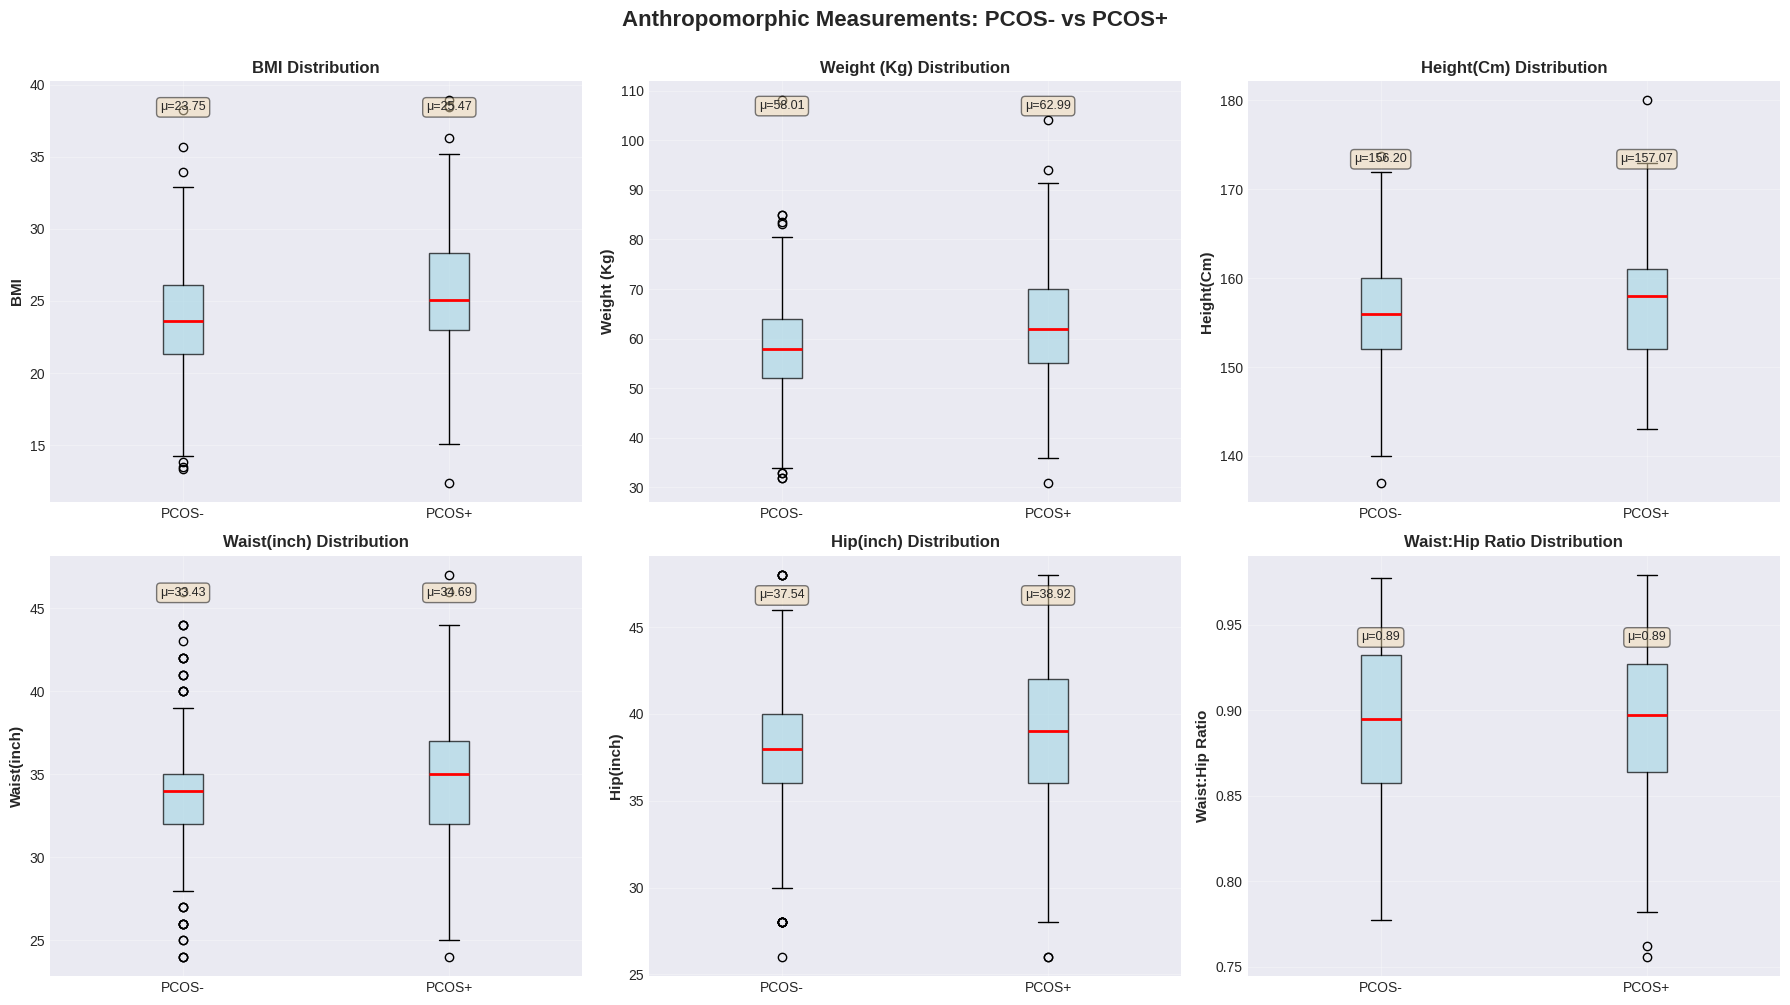

In [6]:
# Compare key anthropomorphic measurements between PCOS groups
anthropomorphic_features = ['BMI', 'Weight (Kg)', 'Height(Cm) ', 'Waist(inch)', 'Hip(inch)', 'Waist:Hip Ratio']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, feature in enumerate(anthropomorphic_features):
    # Box plot comparison
    data_to_plot = [pcos_negative[feature].dropna(), pcos_positive[feature].dropna()]
    bp = axes[idx].boxplot(data_to_plot, labels=['PCOS-', 'PCOS+'], patch_artist=True,
                            boxprops=dict(facecolor='lightblue', alpha=0.7),
                            medianprops=dict(color='red', linewidth=2))
    
    axes[idx].set_ylabel(feature.strip(), fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{feature.strip()} Distribution', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    
    # Add mean values
    mean_neg = pcos_negative[feature].mean()
    mean_pos = pcos_positive[feature].mean()
    axes[idx].text(1, axes[idx].get_ylim()[1]*0.95, f'μ={mean_neg:.2f}', 
                   ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[idx].text(2, axes[idx].get_ylim()[1]*0.95, f'μ={mean_pos:.2f}', 
                   ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Anthropomorphic Measurements: PCOS- vs PCOS+', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [7]:
# # Compare hormonal markers
# hormonal_features = ['FSH(mIU/mL)', 'LH(mIU/mL)', 'FSH/LH', 'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)']

# fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# axes = axes.ravel()

# for idx, feature in enumerate(hormonal_features):
#     # Violin plot for better distribution visualization
#     parts = axes[idx].violinplot([pcos_negative[feature].dropna(), pcos_positive[feature].dropna()],
#                                   positions=[1, 2], showmeans=True, showmedians=True)
    
#     axes[idx].set_xticks([1, 2])
#     axes[idx].set_xticklabels(['PCOS-', 'PCOS+'])
#     axes[idx].set_ylabel(feature.strip(), fontsize=11, fontweight='bold')
#     axes[idx].set_title(f'{feature.strip()} Distribution', fontsize=12, fontweight='bold')
#     axes[idx].grid(True, alpha=0.3, axis='y')

# plt.suptitle('Hormonal Markers: PCOS- vs PCOS+', fontsize=16, fontweight='bold', y=1.00)
# plt.tight_layout()
# plt.show()

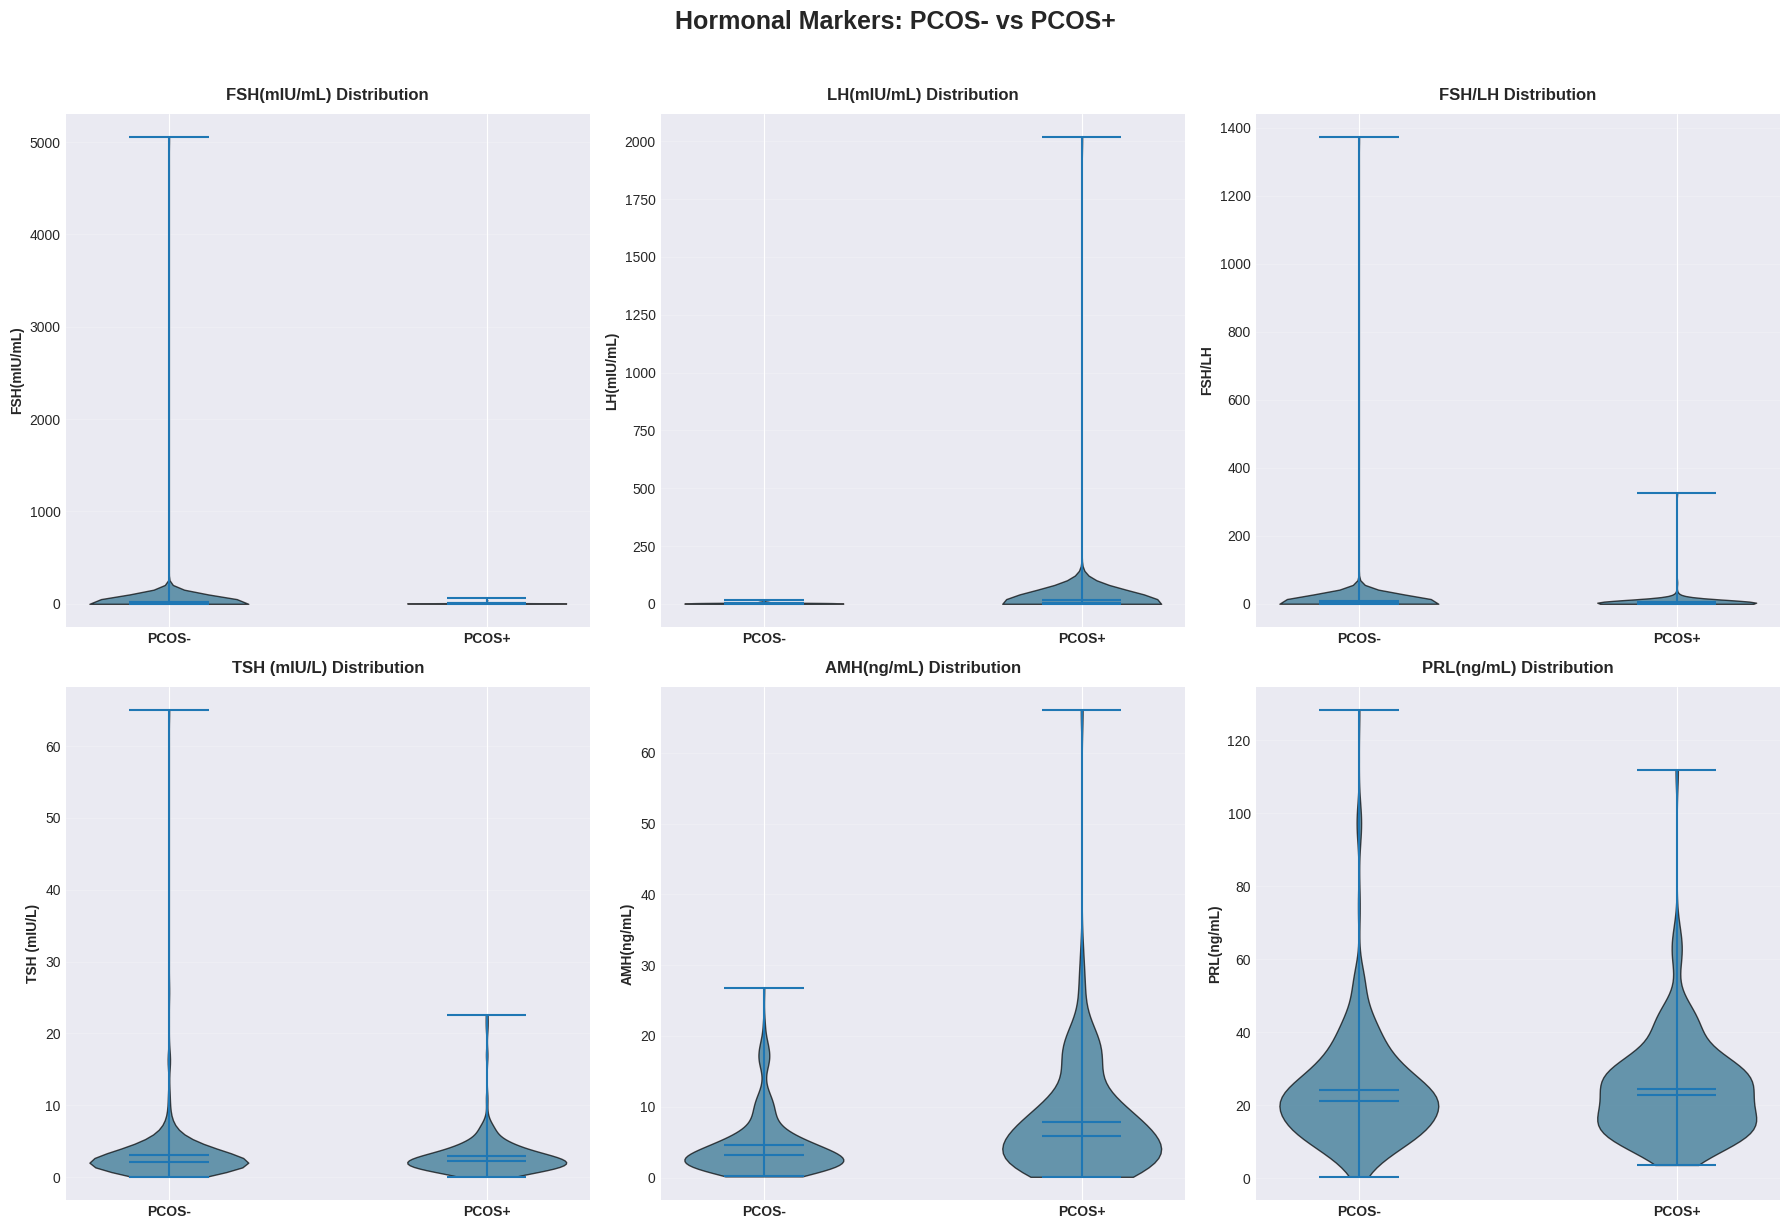

In [8]:
# 1. Preprocessing: Ensure columns are numeric
# This converts strings/errors to NaN, which your .dropna() then handles.
hormonal_features = ['FSH(mIU/mL)', 'LH(mIU/mL)', 'FSH/LH', 'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)']

for col in hormonal_features:
    pcos_negative[col] = pd.to_numeric(pcos_negative[col], errors='coerce')
    pcos_positive[col] = pd.to_numeric(pcos_positive[col], errors='coerce')

# 2. Setup the Plotting Area
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# 3. Generate the Plots
for idx, feature in enumerate(hormonal_features):
    # Clean the data for the specific plot
    data_neg = pcos_negative[feature].dropna()
    data_pos = pcos_positive[feature].dropna()
    
    # Create the violin plot
    parts = axes[idx].violinplot([data_neg, data_pos],
                                 positions=[1, 2], 
                                 showmeans=True, 
                                 showmedians=True)
    
    # Styling the specific subplot
    axes[idx].set_xticks([1, 2])
    axes[idx].set_xticklabels(['PCOS-', 'PCOS+'], fontweight='bold')
    axes[idx].set_ylabel(feature.strip(), fontsize=10, fontweight='bold')
    axes[idx].set_title(f'{feature.strip()} Distribution', fontsize=12, fontweight='bold', pad=10)
    axes[idx].grid(True, alpha=0.2, axis='y')
    
    # Optional: Color the violins for better distinction
    for pc in parts['bodies']:
        pc.set_facecolor('#2D708E') # Darker teal
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

# 4. Final Layout Adjustments
plt.suptitle('Hormonal Markers: PCOS- vs PCOS+', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

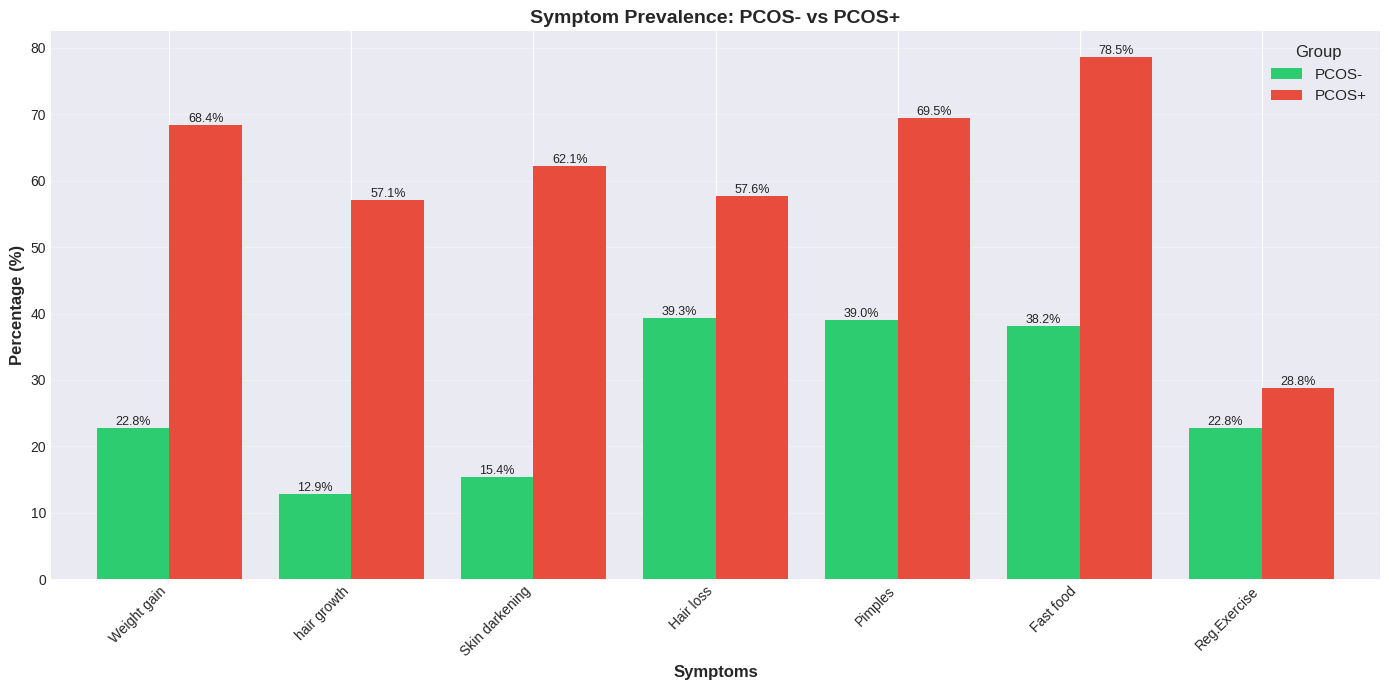

In [9]:
# Compare symptoms between groups
symptom_features = ['Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 
                    'Hair loss(Y/N)', 'Pimples(Y/N)', 'Fast food (Y/N)', 'Reg.Exercise(Y/N)']

# Calculate percentages for each symptom
symptom_comparison = pd.DataFrame()
for symptom in symptom_features:
    pcos_neg_pct = (pcos_negative[symptom].sum() / len(pcos_negative) * 100)
    pcos_pos_pct = (pcos_positive[symptom].sum() / len(pcos_positive) * 100)
    symptom_comparison[symptom] = [pcos_neg_pct, pcos_pos_pct]

symptom_comparison.index = ['PCOS-', 'PCOS+']
symptom_comparison = symptom_comparison.T

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(14, 7))
symptom_comparison.plot(kind='bar', ax=ax, color=['#2ecc71', '#e74c3c'], width=0.8)
ax.set_xlabel('Symptoms', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax.set_title('Symptom Prevalence: PCOS- vs PCOS+', fontsize=14, fontweight='bold')
ax.legend(title='Group', fontsize=11, title_fontsize=12)
ax.set_xticklabels([s.replace('(Y/N)', '').strip() for s in symptom_features], rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=9)

plt.tight_layout()
plt.show()

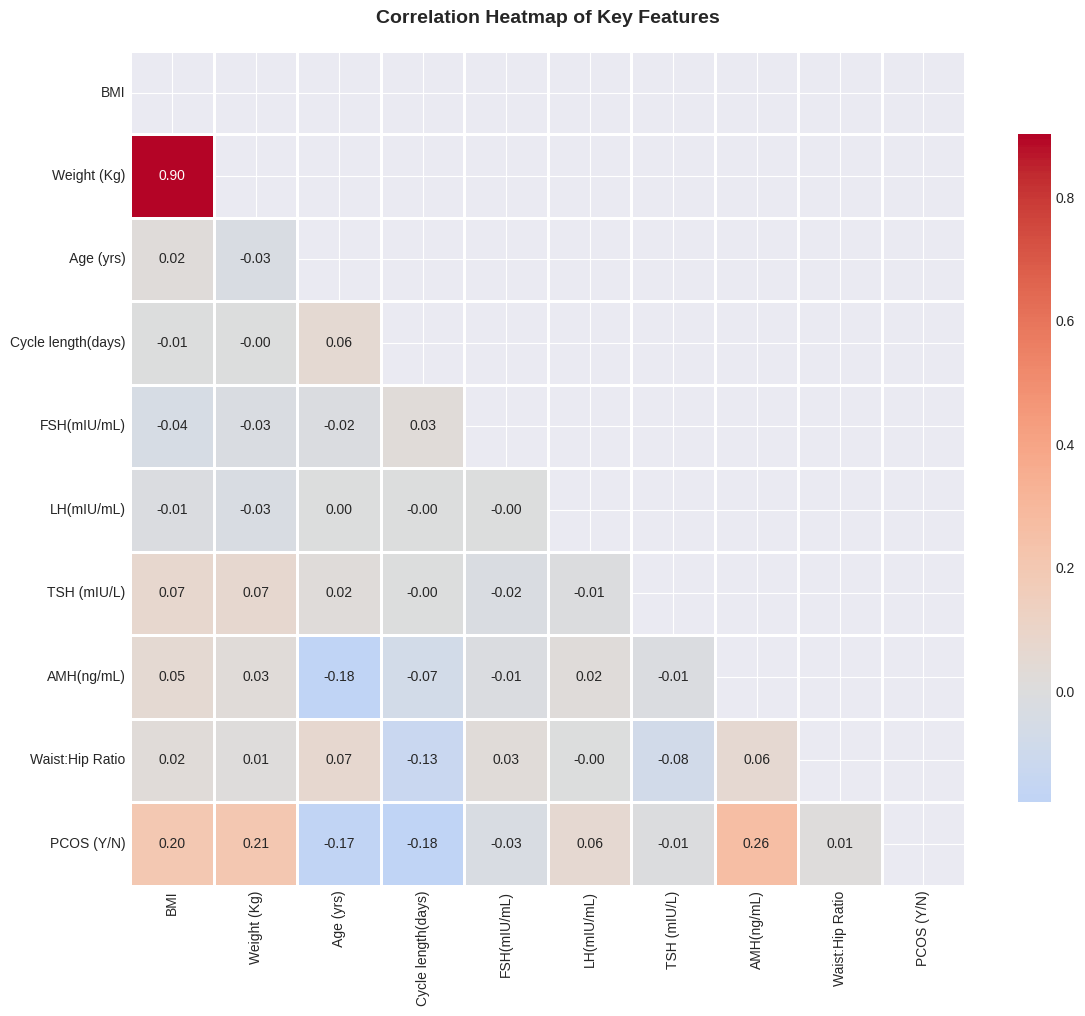

In [11]:
# Correlation heatmap for key numerical features
numerical_features = ['BMI', 'Weight (Kg)', ' Age (yrs)', 'Cycle length(days)', 
                      'FSH(mIU/mL)', 'LH(mIU/mL)', 'TSH (mIU/L)', 'AMH(ng/mL)', 
                      'Waist:Hip Ratio', 'PCOS (Y/N)']

# SANITIZE DATA: Force all selected columns to numeric
# This handles the 'a' error by turning it into a missing value (NaN)
for col in numerical_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

plt.figure(figsize=(12, 10))
correlation_matrix = df[numerical_features].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Key Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [12]:
# # Correlation heatmap for key numerical features
# # 1. Define features (Check for leading/trailing spaces in column names)
# numerical_features = ['BMI', 'Weight (Kg)', ' Age (yrs)', 'Cycle length(days)', 
#                       'FSH(mIU/mL)', 'LH(mIU/mL)', 'TSH (mIU/L)', 'AMH(ng/mL)', 
#                       'Waist:Hip Ratio', 'PCOS (Y/N)']

# # 2. SANITIZE DATA: Force all selected columns to numeric
# # This handles the 'a' error by turning it into a missing value (NaN)
# for col in numerical_features:
#     df[col] = pd.to_numeric(df[col], errors='coerce')

# # 3. Create Correlation Matrix
# # We use numeric_only=True as an extra safety measure
# correlation_matrix = df[numerical_features].corr()

# # 4. Plotting
# plt.figure(figsize=(12, 10))

# # Create a mask for the upper triangle (cleaner look)
# mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# sns.heatmap(correlation_matrix, 
#             mask=mask, 
#             annot=True, 
#             fmt='.2f', 
#             cmap='coolwarm', 
#             center=0, 
#             square=True, 
#             linewidths=1, 
#             cbar_kws={"shrink": 0.8})

# plt.title('Correlation Heatmap of Key Features', fontsize=14, fontweight='bold', pad=20)
# plt.tight_layout()
# plt.show()

## 4. Feature Categorization

Organize features into four distinct categories based on their clinical accessibility and nature:

1. **Anthropomorphic**: Physical measurements (BMI, height, weight, hip/waist measurements)
2. **Symptom**: Self-reported symptoms and lifestyle factors
3. **Given**: Demographic and basic patient information
4. **Test Results**: Clinical laboratory test results (hormonal and metabolic markers)

In [13]:
# Define feature categories
anthropomorphic_features = [
    'BMI', 'Height(Cm) ', 'Hip(inch)', 'Waist(inch)', 'Waist:Hip Ratio', 'Weight (Kg)'
]

symptom_features = [
    'Skin darkening (Y/N)', 'Pimples(Y/N)', 'Hair loss(Y/N)', 'hair growth(Y/N)',
    'Cycle(R/I)', 'Cycle length(days)', 'Weight gain(Y/N)', 'Fast food (Y/N)', 'Reg.Exercise(Y/N)'
]

given_features = [
    ' Age (yrs)', 'Blood Group', 'Marraige Status (Yrs)', 'Pregnant(Y/N)', 'No. of aborptions'
]

test_result_features = [
    'Pulse rate(bpm) ', 'RR (breaths/min)', 'Hb(g/dl)', 
    '  I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 
    'FSH(mIU/mL)', 'LH(mIU/mL)', 'FSH/LH', 'TSH (mIU/L)', 'AMH(ng/mL)', 
    'PRL(ng/mL)', 'Vit D3 (ng/mL)', 'PRG(ng/mL)', 'RBS(mg/dl)', 
    'BP _Systolic (mmHg)', 'BP _Diastolic (mmHg)', 
    'Follicle No. (L)', 'Follicle No. (R)', 
    'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)'
]

# Print feature counts
print("Feature Categorization Summary:")
print("="*80)
print(f"Anthropomorphic features: {len(anthropomorphic_features)}")
print(f"  → {', '.join(anthropomorphic_features[:3])}...\n")

print(f"Symptom features: {len(symptom_features)}")
print(f"  → {', '.join(symptom_features[:3])}...\n")

print(f"Given features: {len(given_features)}")
print(f"  → {', '.join(given_features[:3])}...\n")

print(f"Test result features: {len(test_result_features)}")
print(f"  → {', '.join(test_result_features[:3])}...\n")

# Patient Model features (non-invasive)
patient_model_features = anthropomorphic_features + symptom_features + given_features
print(f"Patient Model (non-invasive) features: {len(patient_model_features)}")

# Provider Model features (all features)
provider_model_features = patient_model_features + test_result_features
print(f"Provider Model (all) features: {len(provider_model_features)}")
print("="*80)

Feature Categorization Summary:
Anthropomorphic features: 6
  → BMI, Height(Cm) , Hip(inch)...

Symptom features: 9
  → Skin darkening (Y/N), Pimples(Y/N), Hair loss(Y/N)...

Given features: 5
  →  Age (yrs), Blood Group, Marraige Status (Yrs)...

Test result features: 21
  → Pulse rate(bpm) , RR (breaths/min), Hb(g/dl)...

Patient Model (non-invasive) features: 20
Provider Model (all) features: 41


## 5. Data Preprocessing and Encoding

Clean and prepare the data for machine learning:
- Handle missing values
- Encode categorical variables
- Standardize numerical features

In [14]:
# Create a clean copy for processing
df_processed = df.copy()

# Handle missing values - fill with median for numerical, mode for categorical
for col in df_processed.columns:
    if col == 'PCOS (Y/N)':
        continue
    if df_processed[col].dtype in ['float64', 'int64']:
        df_processed[col].fillna(df_processed[col].median(), inplace=True)
    else:
        df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

print("Missing values after imputation:")
print(df_processed.isnull().sum().sum())

# Encode categorical variables
# Blood Group
if 'Blood Group' in df_processed.columns:
    le_blood = LabelEncoder()
    df_processed['Blood Group'] = le_blood.fit_transform(df_processed['Blood Group'].astype(str))

# Cycle (R/I) - Regular or Irregular
if 'Cycle(R/I)' in df_processed.columns:
    df_processed['Cycle(R/I)'] = df_processed['Cycle(R/I)'].map({2: 0, 4: 1, 5: 1})  # 2=Regular, 4/5=Irregular
    df_processed['Cycle(R/I)'].fillna(df_processed['Cycle(R/I)'].mode()[0], inplace=True)

print("\n✅ Data preprocessing completed!")
print(f"Processed dataset shape: {df_processed.shape}")

Missing values after imputation:
0

✅ Data preprocessing completed!
Processed dataset shape: (541, 42)


In [15]:
# Prepare feature matrices and target
X = df_processed.drop('PCOS (Y/N)', axis=1)
y = df_processed['PCOS (Y/N)']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts())

Feature matrix shape: (541, 41)
Target vector shape: (541,)

Target distribution:
PCOS (Y/N)
0    364
1    177
Name: count, dtype: int64


## 6. Principal Component Analysis (PCA) on Anthropomorphic Variables

Apply PCA to reduce dimensionality of anthropomorphic measurements and visualize the variance explained by principal components.

In [16]:
# Extract anthropomorphic features for PCA
X_anthropo = df_processed[anthropomorphic_features].copy()

# Standardize features before PCA
scaler_pca = StandardScaler()
X_anthropo_scaled = scaler_pca.fit_transform(X_anthropo)

# Apply PCA
pca = PCA(n_components=len(anthropomorphic_features), random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X_anthropo_scaled)

# Create DataFrame with principal components
pca_columns = [f'PC{i+1}' for i in range(pca.n_components_)]
df_pca = pd.DataFrame(X_pca, columns=pca_columns)
df_pca['PCOS'] = y.values

print("PCA Results:")
print("="*80)
print(f"Number of components: {pca.n_components_}")
print(f"\nExplained variance ratio:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {var:.4f} ({var*100:.2f}%)")
print(f"\nCumulative explained variance:")
cumsum = np.cumsum(pca.explained_variance_ratio_)
for i, var in enumerate(cumsum):
    print(f"  PC1-PC{i+1}: {var:.4f} ({var*100:.2f}%)")

PCA Results:
Number of components: 6

Explained variance ratio:
  PC1: 0.5348 (53.48%)
  PC2: 0.1881 (18.81%)
  PC3: 0.1685 (16.85%)
  PC4: 0.1080 (10.80%)
  PC5: 0.0004 (0.04%)
  PC6: 0.0002 (0.02%)

Cumulative explained variance:
  PC1-PC1: 0.5348 (53.48%)
  PC1-PC2: 0.7229 (72.29%)
  PC1-PC3: 0.8913 (89.13%)
  PC1-PC4: 0.9994 (99.94%)
  PC1-PC5: 0.9998 (99.98%)
  PC1-PC6: 1.0000 (100.00%)


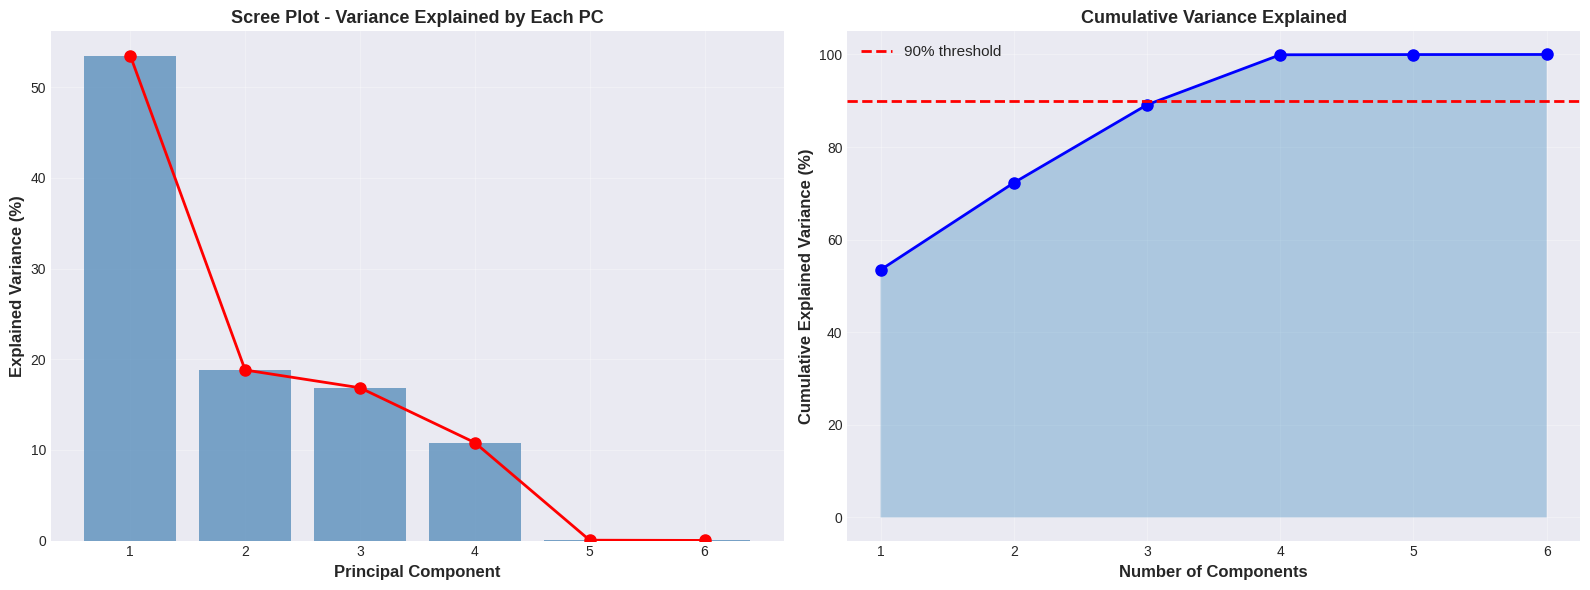

In [17]:
# Visualize explained variance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scree plot
axes[0].bar(range(1, len(pca.explained_variance_ratio_) + 1), 
            pca.explained_variance_ratio_ * 100, alpha=0.7, color='steelblue')
axes[0].plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             pca.explained_variance_ratio_ * 100, 'ro-', linewidth=2, markersize=8)
axes[0].set_xlabel('Principal Component', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Explained Variance (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Scree Plot - Variance Explained by Each PC', fontsize=13, fontweight='bold')
axes[0].set_xticks(range(1, len(pca.explained_variance_ratio_) + 1))
axes[0].grid(True, alpha=0.3)

# Cumulative variance plot
cumsum = np.cumsum(pca.explained_variance_ratio_) * 100
axes[1].plot(range(1, len(cumsum) + 1), cumsum, 'bo-', linewidth=2, markersize=8)
axes[1].axhline(y=90, color='r', linestyle='--', linewidth=2, label='90% threshold')
axes[1].fill_between(range(1, len(cumsum) + 1), cumsum, alpha=0.3)
axes[1].set_xlabel('Number of Components', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cumulative Explained Variance (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Cumulative Variance Explained', fontsize=13, fontweight='bold')
axes[1].set_xticks(range(1, len(cumsum) + 1))
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

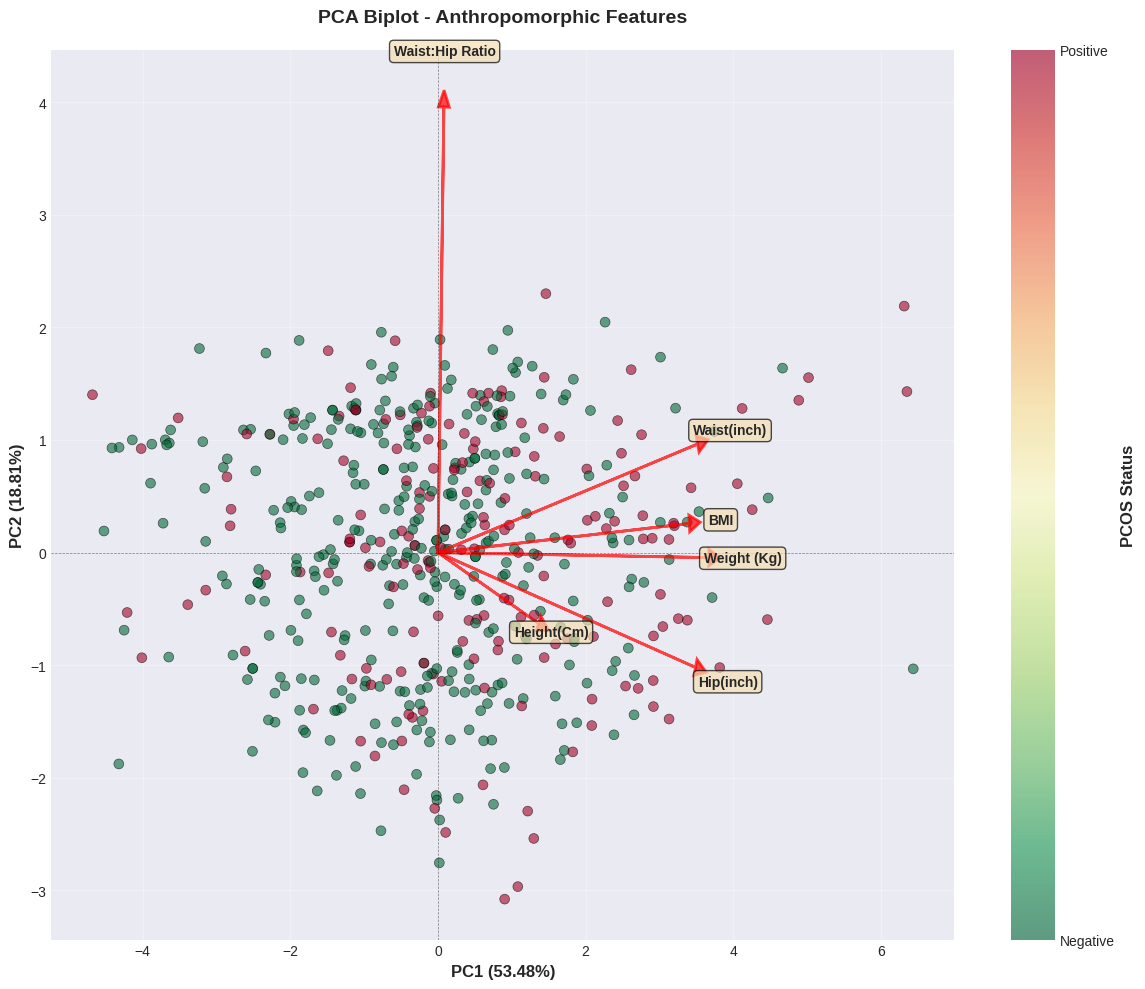

In [18]:
# PCA Biplot - visualize loadings and samples
fig, ax = plt.subplots(figsize=(12, 10))

# Plot samples
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='RdYlGn_r', 
                    alpha=0.6, s=50, edgecolors='k', linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('PCOS Status', fontsize=12, fontweight='bold')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Negative', 'Positive'])

# Plot loadings as arrows
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
for i, feature in enumerate(anthropomorphic_features):
    ax.arrow(0, 0, loadings[i, 0]*4, loadings[i, 1]*4, 
             head_width=0.15, head_length=0.15, fc='red', ec='red', linewidth=2, alpha=0.7)
    ax.text(loadings[i, 0]*4.5, loadings[i, 1]*4.5, feature.strip(), 
            fontsize=10, fontweight='bold', ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)', fontsize=12, fontweight='bold')
ax.set_title('PCA Biplot - Anthropomorphic Features', fontsize=14, fontweight='bold', pad=20)
ax.axhline(y=0, color='k', linewidth=0.5, linestyle='--', alpha=0.5)
ax.axvline(x=0, color='k', linewidth=0.5, linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

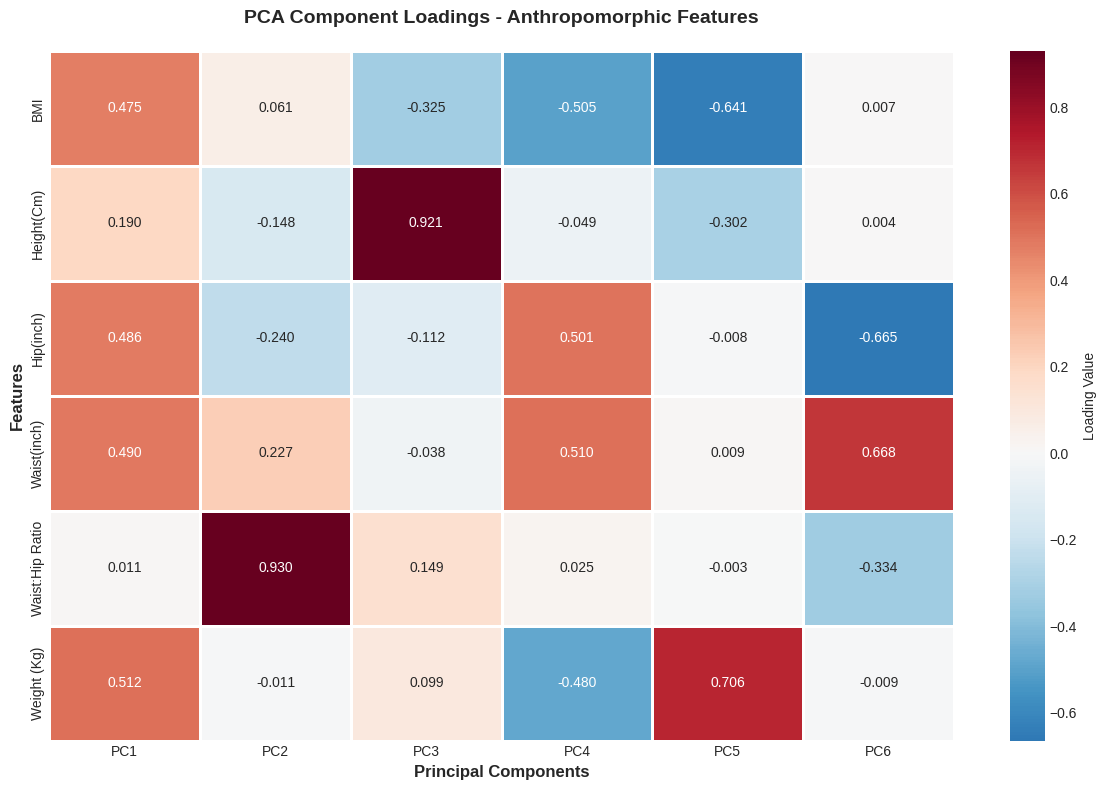

In [19]:
# Component loadings heatmap
plt.figure(figsize=(12, 8))
loadings_df = pd.DataFrame(
    pca.components_.T,
    columns=pca_columns,
    index=[f.strip() for f in anthropomorphic_features]
)
sns.heatmap(loadings_df, annot=True, fmt='.3f', cmap='RdBu_r', center=0, 
            cbar_kws={'label': 'Loading Value'}, linewidths=1)
plt.title('PCA Component Loadings - Anthropomorphic Features', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Principal Components', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. K-Means Clustering on Principal Components

Apply K-means clustering (k=2) on the first 5 principal components to identify distinct patient subgroups.

In [20]:
# Apply K-means clustering on first 5 PCs
n_components_cluster = 5
X_pca_cluster = X_pca[:, :n_components_cluster]

# K-means with k=2
kmeans = KMeans(n_clusters=2, random_state=RANDOM_SEED, n_init=100, max_iter=500)
clusters = kmeans.fit_predict(X_pca_cluster)

# Add cluster labels to dataframe
df_processed['Cluster'] = clusters
df_pca['Cluster'] = clusters

print("K-Means Clustering Results:")
print("="*80)
print(f"Number of clusters: 2")
print(f"Features used: First {n_components_cluster} principal components")
print(f"\nCluster distribution:")
print(pd.Series(clusters).value_counts().sort_index())

# Cross-tabulation of clusters with PCOS status
print("\nCluster vs PCOS Status:")
crosstab = pd.crosstab(clusters, y, rownames=['Cluster'], colnames=['PCOS'])
print(crosstab)
print("\nPercentage distribution:")
print(pd.crosstab(clusters, y, normalize='index') * 100)

K-Means Clustering Results:
Number of clusters: 2
Features used: First 5 principal components

Cluster distribution:
0    247
1    294
Name: count, dtype: int64

Cluster vs PCOS Status:
PCOS       0   1
Cluster         
0        148  99
1        216  78

Percentage distribution:
PCOS (Y/N)          0          1
row_0                           
0           59.919028  40.080972
1           73.469388  26.530612


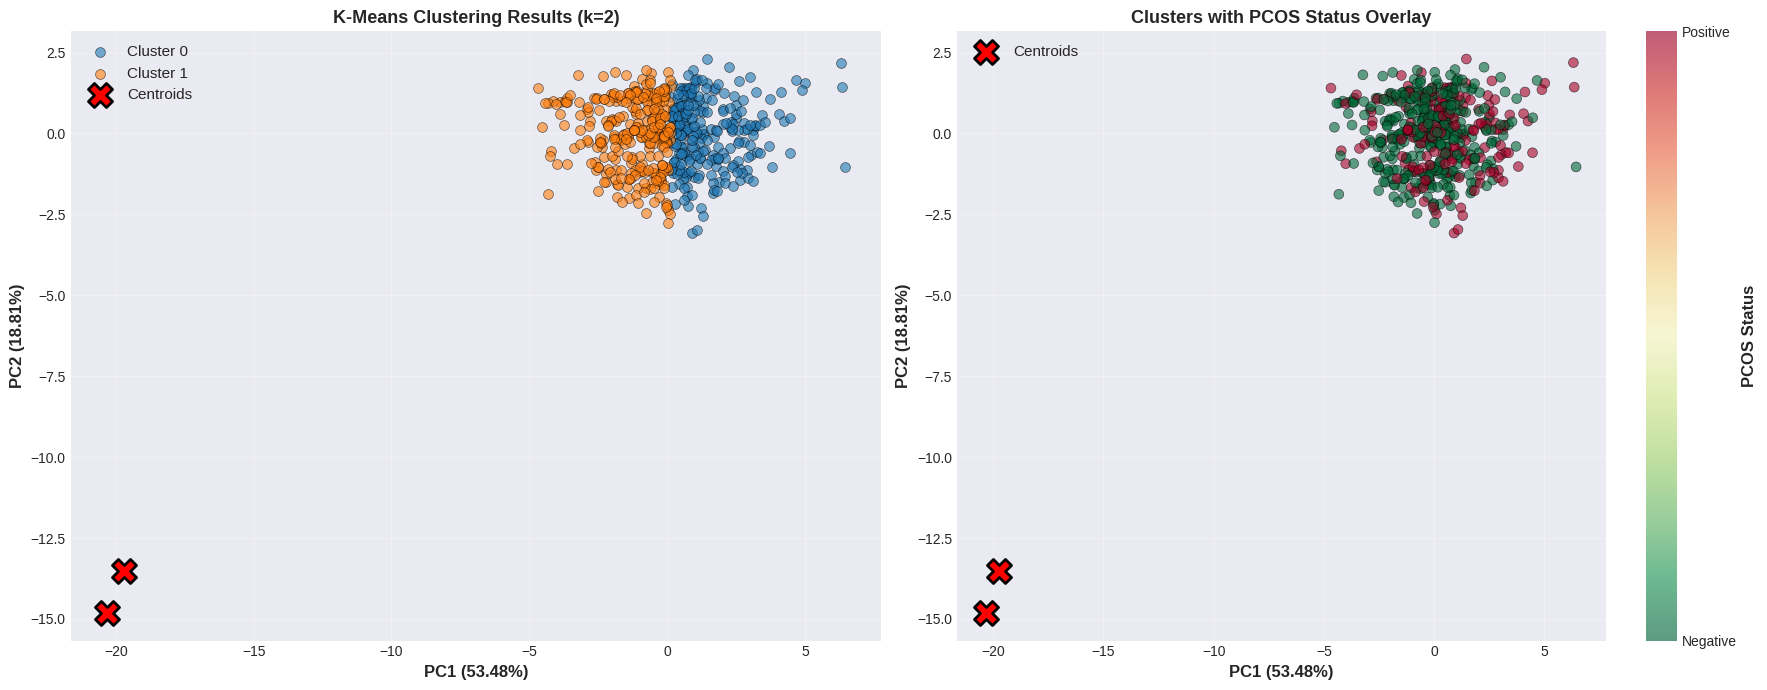

In [21]:
# Visualize clusters in PC space
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Left plot: Clusters colored by cluster assignment
for cluster_id in range(2):
    mask = clusters == cluster_id
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   label=f'Cluster {cluster_id}', alpha=0.6, s=50, edgecolors='k', linewidth=0.5)

# Plot cluster centers
centers_original = pca.inverse_transform(
    np.column_stack([kmeans.cluster_centers_, np.zeros((2, pca.n_components_ - n_components_cluster))])
)
centers_pca = pca.transform(scaler_pca.transform(centers_original))
axes[0].scatter(centers_pca[:, 0], centers_pca[:, 1], 
               marker='X', s=300, c='red', edgecolors='black', linewidth=2, label='Centroids')

axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)', fontsize=12, fontweight='bold')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)', fontsize=12, fontweight='bold')
axes[0].set_title('K-Means Clustering Results (k=2)', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Right plot: Clusters colored by PCOS status
scatter = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='RdYlGn_r', 
                         alpha=0.6, s=50, edgecolors='k', linewidth=0.5)
axes[1].scatter(centers_pca[:, 0], centers_pca[:, 1], 
               marker='X', s=300, c='red', edgecolors='black', linewidth=2, label='Centroids')

cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('PCOS Status', fontsize=12, fontweight='bold')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Negative', 'Positive'])

axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)', fontsize=12, fontweight='bold')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)', fontsize=12, fontweight='bold')
axes[1].set_title('Clusters with PCOS Status Overlay', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Subgroup Characteristics Comparison

Analyze and compare the characteristics of identified patient subgroups (clusters).

In [22]:
# Compare anthropomorphic features across clusters
print("Anthropomorphic Features by Cluster:")
print("="*80)
cluster_comparison = df_processed.groupby('Cluster')[anthropomorphic_features].mean()
print(cluster_comparison.T)

# Statistical comparison
print("\n" + "="*80)
print("Statistical Significance (t-test p-values):")
print("="*80)
cluster0_data = df_processed[df_processed['Cluster'] == 0]
cluster1_data = df_processed[df_processed['Cluster'] == 1]

for feature in anthropomorphic_features:
    stat, pval = ttest_ind(cluster0_data[feature], cluster1_data[feature])
    sig = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else "ns"
    print(f"{feature:30s}: p={pval:.4f} {sig}")

Anthropomorphic Features by Cluster:
Cluster                   0           1
BMI               27.230565   21.858692
Height(Cm)       158.434737  154.846653
Hip(inch)         40.757085   35.670068
Waist(inch)       36.392713   31.697279
Waist:Hip Ratio    0.893521    0.890528
Weight (Kg)       68.291498   52.366327

Statistical Significance (t-test p-values):
BMI                           : p=0.0000 ***
Height(Cm)                    : p=0.0000 ***
Hip(inch)                     : p=0.0000 ***
Waist(inch)                   : p=0.0000 ***
Waist:Hip Ratio               : p=0.4545 ns
Weight (Kg)                   : p=0.0000 ***


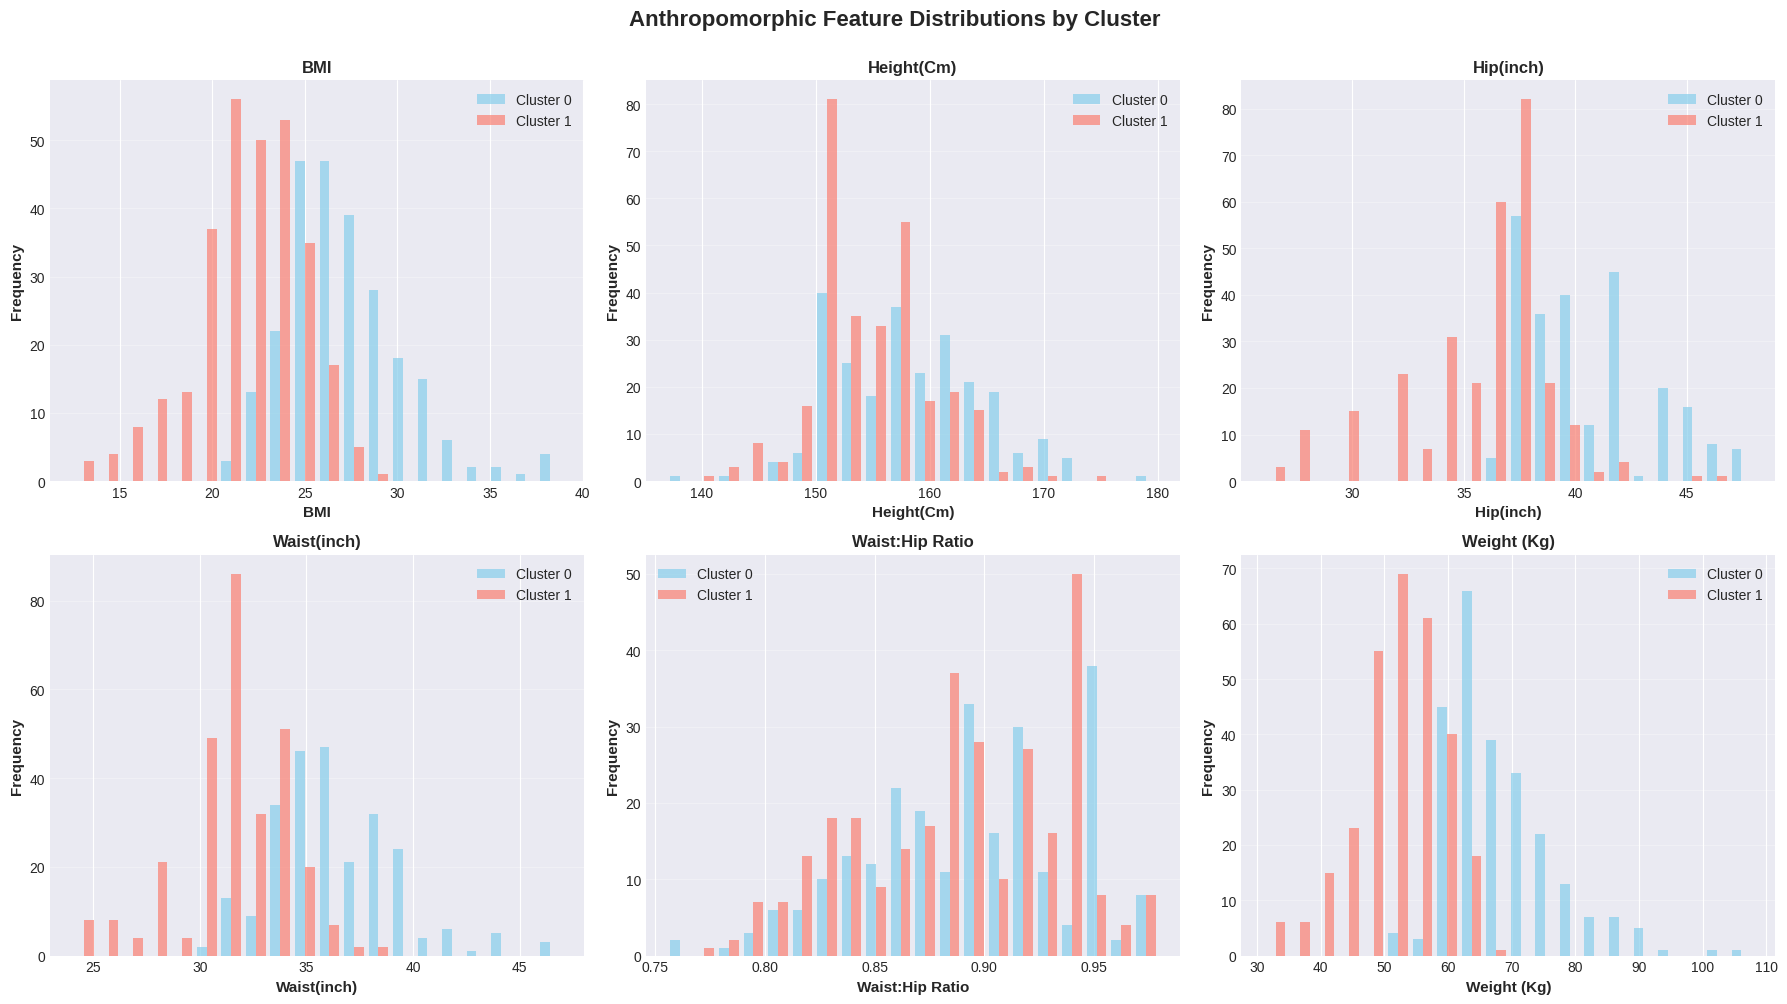

In [23]:
# Visualize cluster characteristics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, feature in enumerate(anthropomorphic_features):
    cluster0_vals = cluster0_data[feature].values
    cluster1_vals = cluster1_data[feature].values
    
    axes[idx].hist([cluster0_vals, cluster1_vals], bins=20, alpha=0.7, 
                   label=['Cluster 0', 'Cluster 1'], color=['skyblue', 'salmon'])
    axes[idx].set_xlabel(feature.strip(), fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[idx].set_title(feature.strip(), fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=10)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Anthropomorphic Feature Distributions by Cluster', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

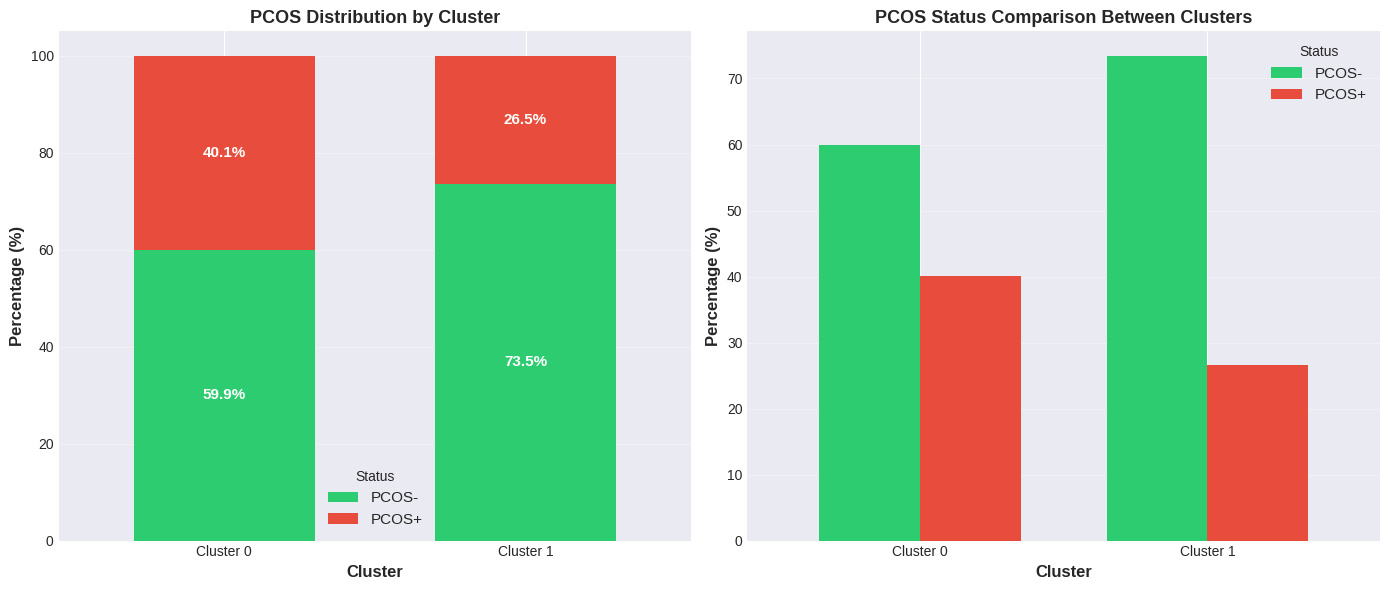


PCOS Distribution by Cluster:
PCOS (Y/N)          0          1
Cluster                         
0           59.919028  40.080972
1           73.469388  26.530612


In [24]:
# Compare PCOS prevalence across clusters
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Stacked bar chart
cluster_pcos = pd.crosstab(df_processed['Cluster'], df_processed['PCOS (Y/N)'])
cluster_pcos_pct = pd.crosstab(df_processed['Cluster'], df_processed['PCOS (Y/N)'], normalize='index') * 100

cluster_pcos_pct.plot(kind='bar', stacked=True, ax=axes[0], color=['#2ecc71', '#e74c3c'], width=0.6)
axes[0].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
axes[0].set_title('PCOS Distribution by Cluster', fontsize=13, fontweight='bold')
axes[0].set_xticklabels(['Cluster 0', 'Cluster 1'], rotation=0)
axes[0].legend(['PCOS-', 'PCOS+'], title='Status', fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# Add percentage labels
for i, cluster in enumerate(cluster_pcos_pct.index):
    cumsum = 0
    for j, val in enumerate(cluster_pcos_pct.loc[cluster]):
        axes[0].text(i, cumsum + val/2, f'{val:.1f}%', 
                    ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        cumsum += val

# Grouped bar chart
cluster_pcos_pct.plot(kind='bar', ax=axes[1], color=['#2ecc71', '#e74c3c'], width=0.7)
axes[1].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
axes[1].set_title('PCOS Status Comparison Between Clusters', fontsize=13, fontweight='bold')
axes[1].set_xticklabels(['Cluster 0', 'Cluster 1'], rotation=0)
axes[1].legend(['PCOS-', 'PCOS+'], title='Status', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nPCOS Distribution by Cluster:")
print(cluster_pcos_pct)

## 9. Patient Model - Non-invasive Features Only

Build PCOS prediction models using only non-invasive features (anthropomorphic, symptom, and given features).

### 9.1 One-to-All Model (All Patients)

Train a single model on all patients with 5-fold cross-validation repeated 3 times.

In [25]:
# Prepare data for Patient Model
X_patient = df_processed[patient_model_features].copy()
y_patient = df_processed['PCOS (Y/N)'].copy()

print("Patient Model Configuration:")
print("="*80)
print(f"Features: {len(patient_model_features)}")
print(f"Samples: {len(X_patient)}")
print(f"Feature categories:")
print(f"  - Anthropomorphic: {len(anthropomorphic_features)}")
print(f"  - Symptom: {len(symptom_features)}")
print(f"  - Given: {len(given_features)}")
print("="*80)

Patient Model Configuration:
Features: 20
Samples: 541
Feature categories:
  - Anthropomorphic: 6
  - Symptom: 9
  - Given: 5


In [26]:
# Train One-to-All Patient Model with repeated cross-validation
print("Training One-to-All Patient Model...\n")

# CatBoost classifier with specified parameters
cat_patient_all = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=RANDOM_SEED,
    verbose=False
)

# Repeated cross-validation: 5-fold CV x 3 iterations
n_folds = 5
n_repeats = 3
cv_results_patient_all = defaultdict(list)

for repeat in range(n_repeats):
    print(f"Repeat {repeat+1}/{n_repeats}...")
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_SEED + repeat)
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_patient, y_patient)):
        X_train, X_val = X_patient.iloc[train_idx], X_patient.iloc[val_idx]
        y_train, y_val = y_patient.iloc[train_idx], y_patient.iloc[val_idx]
        
        # Train model
        cat_patient_all.fit(X_train, y_train)
        
        # Predictions
        y_pred = cat_patient_all.predict(X_val)
        y_pred_proba = cat_patient_all.predict_proba(X_val)[:, 1]
        
        # Calculate metrics
        cv_results_patient_all['accuracy'].append(accuracy_score(y_val, y_pred))
        cv_results_patient_all['precision'].append(precision_score(y_val, y_pred))
        cv_results_patient_all['recall'].append(recall_score(y_val, y_pred))
        cv_results_patient_all['f1'].append(f1_score(y_val, y_pred))
        cv_results_patient_all['auc'].append(roc_auc_score(y_val, y_pred_proba))

# Calculate mean and std
print("\n" + "="*80)
print("One-to-All Patient Model Performance (5-fold CV x 3 repeats):")
print("="*80)
for metric, values in cv_results_patient_all.items():
    print(f"{metric.capitalize():12s}: {np.mean(values):.4f} ± {np.std(values):.4f}")
print("="*80)

Training One-to-All Patient Model...

Repeat 1/3...
Repeat 2/3...
Repeat 3/3...

One-to-All Patient Model Performance (5-fold CV x 3 repeats):
Accuracy    : 0.8158 ± 0.0230
Precision   : 0.7493 ± 0.0536
Recall      : 0.6651 ± 0.0759
F1          : 0.7011 ± 0.0445
Auc         : 0.8708 ± 0.0297


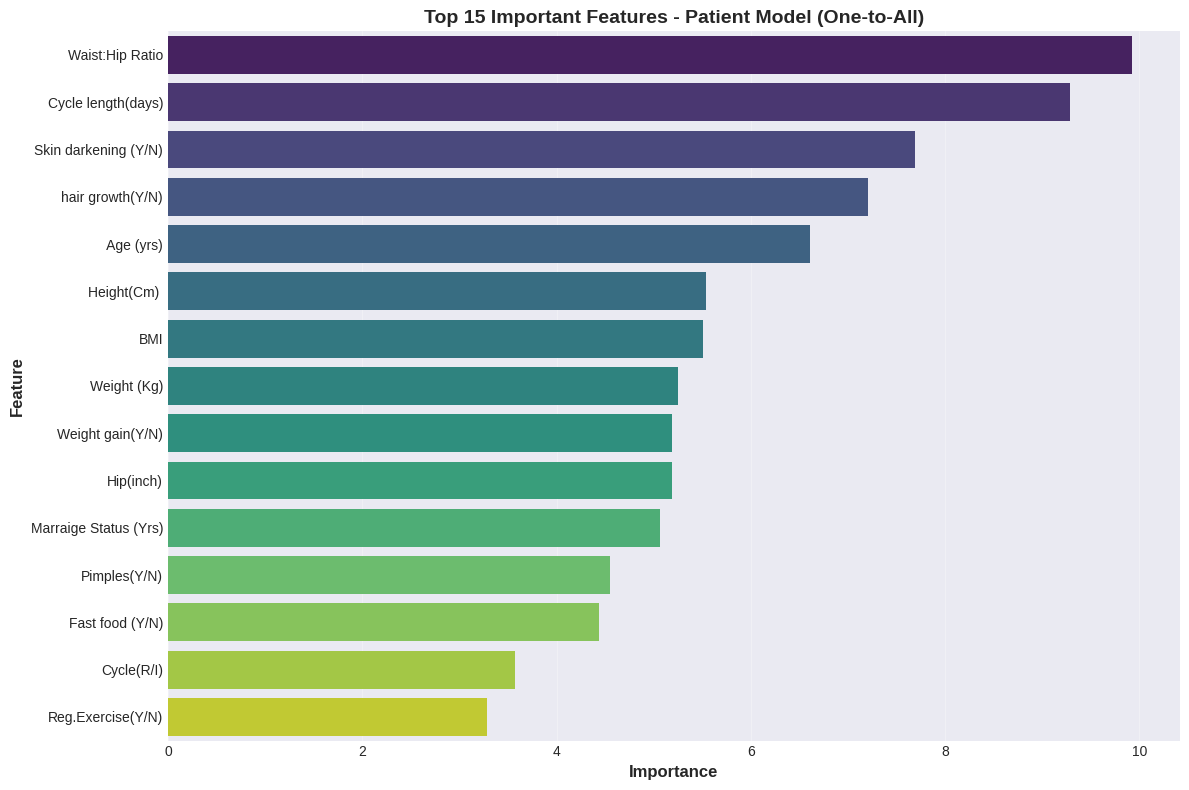

In [27]:
# Train final model on all data for feature importance and SHAP
cat_patient_all_final = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=RANDOM_SEED,
    verbose=False
)
cat_patient_all_final.fit(X_patient, y_patient)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_patient.columns,
    'importance': cat_patient_all_final.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(12, 8))
top_n = 15
sns.barplot(data=feature_importance.head(top_n), x='importance', y='feature', palette='viridis')
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Important Features - Patient Model (One-to-All)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### 9.2 Subgroup-Specific Patient Models

Train separate models for each cluster with 3-fold cross-validation repeated 5 times.

In [28]:
# Train Subgroup Patient Models with repeated cross-validation
n_folds_subgroup = 3
n_repeats_subgroup = 5
cv_results_patient_subgroups = {}

for cluster_id in range(2):
    print(f"\nTraining Patient Model for Cluster {cluster_id}...")
    print("="*80)
    
    # Filter data for this cluster
    cluster_mask = df_processed['Cluster'] == cluster_id
    X_cluster = X_patient[cluster_mask]
    y_cluster = y_patient[cluster_mask]
    
    print(f"Cluster {cluster_id} size: {len(X_cluster)}")
    print(f"PCOS distribution: {y_cluster.value_counts().to_dict()}")
    
    # Initialize CatBoost classifier
    cat_patient_cluster = CatBoostClassifier(
        iterations=500,
        learning_rate=0.1,
        depth=6,
        random_seed=RANDOM_SEED,
        verbose=False
    )
    
    # Repeated cross-validation: 3-fold CV x 5 iterations
    cv_results = defaultdict(list)
    
    for repeat in range(n_repeats_subgroup):
        skf = StratifiedKFold(n_splits=n_folds_subgroup, shuffle=True, random_state=RANDOM_SEED + repeat)
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_cluster, y_cluster)):
            X_train, X_val = X_cluster.iloc[train_idx], X_cluster.iloc[val_idx]
            y_train, y_val = y_cluster.iloc[train_idx], y_cluster.iloc[val_idx]
            
            # Train model
            cat_patient_cluster.fit(X_train, y_train)
            
            # Predictions
            y_pred = cat_patient_cluster.predict(X_val)
            y_pred_proba = cat_patient_cluster.predict_proba(X_val)[:, 1]
            
            # Calculate metrics
            cv_results['accuracy'].append(accuracy_score(y_val, y_pred))
            cv_results['precision'].append(precision_score(y_val, y_pred))
            cv_results['recall'].append(recall_score(y_val, y_pred))
            cv_results['f1'].append(f1_score(y_val, y_pred))
            cv_results['auc'].append(roc_auc_score(y_val, y_pred_proba))
    
    cv_results_patient_subgroups[cluster_id] = cv_results
    
    # Print results
    print(f"\nCluster {cluster_id} Performance (3-fold CV x 5 repeats):")
    for metric, values in cv_results.items():
        print(f"{metric.capitalize():12s}: {np.mean(values):.4f} ± {np.std(values):.4f}")
    print("="*80)


Training Patient Model for Cluster 0...
Cluster 0 size: 247
PCOS distribution: {0: 148, 1: 99}

Cluster 0 Performance (3-fold CV x 5 repeats):
Accuracy    : 0.8082 ± 0.0385
Precision   : 0.7718 ± 0.0562
Recall      : 0.7455 ± 0.0671
F1          : 0.7564 ± 0.0498
Auc         : 0.8785 ± 0.0275

Training Patient Model for Cluster 1...
Cluster 1 size: 294
PCOS distribution: {0: 216, 1: 78}

Cluster 1 Performance (3-fold CV x 5 repeats):
Accuracy    : 0.8075 ± 0.0247
Precision   : 0.6940 ± 0.0767
Recall      : 0.5000 ± 0.0579
F1          : 0.5790 ± 0.0540
Auc         : 0.8119 ± 0.0297


### 9.3 Patient Model Performance Comparison

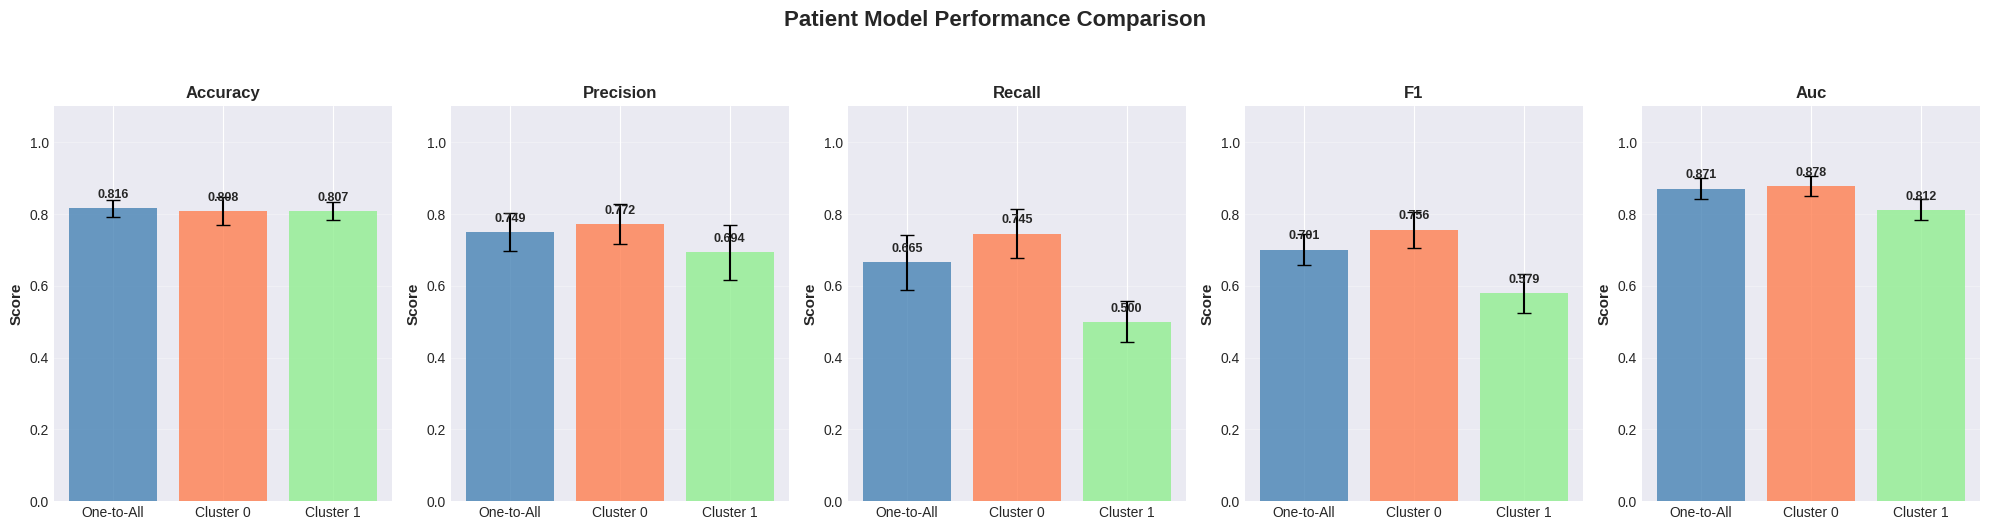


Detailed Performance Comparison - Patient Models:
Model      Cluster 0  Cluster 1  One-to-All
Metric                                     
Accuracy    0.808159   0.807483    0.815800
Auc         0.878486   0.811895    0.870812
F1          0.756423   0.578997    0.701081
Precision   0.771776   0.693989    0.749277
Recall      0.745455   0.500000    0.665079


In [29]:
# Compare performance: One-to-All vs Subgroup models
comparison_data = []

# One-to-All model
for metric, values in cv_results_patient_all.items():
    comparison_data.append({
        'Model': 'One-to-All',
        'Metric': metric.capitalize(),
        'Mean': np.mean(values),
        'Std': np.std(values)
    })

# Subgroup models
for cluster_id, cv_results in cv_results_patient_subgroups.items():
    for metric, values in cv_results.items():
        comparison_data.append({
            'Model': f'Cluster {cluster_id}',
            'Metric': metric.capitalize(),
            'Mean': np.mean(values),
            'Std': np.std(values)
        })

comparison_df = pd.DataFrame(comparison_data)

# Plot comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'Auc']
fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5))

for idx, metric in enumerate(metrics):
    metric_data = comparison_df[comparison_df['Metric'] == metric]
    x_pos = np.arange(len(metric_data))
    
    bars = axes[idx].bar(x_pos, metric_data['Mean'].values, 
                         yerr=metric_data['Std'].values, 
                         color=['steelblue', 'coral', 'lightgreen'],
                         alpha=0.8, capsize=5)
    
    axes[idx].set_ylabel('Score', fontsize=11, fontweight='bold')
    axes[idx].set_title(metric, fontsize=12, fontweight='bold')
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(metric_data['Model'].values, rotation=0)
    axes[idx].set_ylim([0, 1.1])
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                      f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Patient Model Performance Comparison', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

# Print detailed comparison
print("\nDetailed Performance Comparison - Patient Models:")
print("="*80)
pivot_table = comparison_df.pivot(index='Metric', columns='Model', values='Mean')
print(pivot_table.to_string())

## 10. Provider Model - All Features

Build PCOS prediction models using all available features including clinical test results.

### 10.1 One-to-All Provider Model

In [30]:
# Prepare data for Provider Model
X_provider = df_processed[provider_model_features].copy()
y_provider = df_processed['PCOS (Y/N)'].copy()

print("Provider Model Configuration:")
print("="*80)
print(f"Features: {len(provider_model_features)}")
print(f"Samples: {len(X_provider)}")
print(f"Feature categories:")
print(f"  - Anthropomorphic: {len(anthropomorphic_features)}")
print(f"  - Symptom: {len(symptom_features)}")
print(f"  - Given: {len(given_features)}")
print(f"  - Test Results: {len(test_result_features)}")
print("="*80)

Provider Model Configuration:
Features: 41
Samples: 541
Feature categories:
  - Anthropomorphic: 6
  - Symptom: 9
  - Given: 5
  - Test Results: 21


In [31]:
# Replace the problematic '1.99.' string with the correct numeric value 1.99
X_provider = X_provider.replace('1.99.', 1.99)

In [32]:
# Train One-to-All Provider Model with repeated cross-validation
print("Training One-to-All Provider Model...\n")

# CatBoost classifier
cat_provider_all = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=RANDOM_SEED,
    verbose=False
)

# Repeated cross-validation: 5-fold CV x 3 iterations
n_folds = 5
n_repeats = 3
cv_results_provider_all = defaultdict(list)

for repeat in range(n_repeats):
    print(f"Repeat {repeat+1}/{n_repeats}...")
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_SEED + repeat)
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_provider, y_provider)):
        X_train, X_val = X_provider.iloc[train_idx], X_provider.iloc[val_idx]
        y_train, y_val = y_provider.iloc[train_idx], y_provider.iloc[val_idx]
        
        # Train model
        cat_provider_all.fit(X_train, y_train)
        
        # Predictions
        y_pred = cat_provider_all.predict(X_val)
        y_pred_proba = cat_provider_all.predict_proba(X_val)[:, 1]
        
        # Calculate metrics
        cv_results_provider_all['accuracy'].append(accuracy_score(y_val, y_pred))
        cv_results_provider_all['precision'].append(precision_score(y_val, y_pred))
        cv_results_provider_all['recall'].append(recall_score(y_val, y_pred))
        cv_results_provider_all['f1'].append(f1_score(y_val, y_pred))
        cv_results_provider_all['auc'].append(roc_auc_score(y_val, y_pred_proba))

# Calculate mean and std
print("\n" + "="*80)
print("One-to-All Provider Model Performance (5-fold CV x 3 repeats):")
print("="*80)
for metric, values in cv_results_provider_all.items():
    print(f"{metric.capitalize():12s}: {np.mean(values):.4f} ± {np.std(values):.4f}")
print("="*80)

Training One-to-All Provider Model...

Repeat 1/3...
Repeat 2/3...
Repeat 3/3...

One-to-All Provider Model Performance (5-fold CV x 3 repeats):
Accuracy    : 0.8977 ± 0.0303
Precision   : 0.8760 ± 0.0460
Recall      : 0.7998 ± 0.0720
F1          : 0.8350 ± 0.0549
Auc         : 0.9497 ± 0.0214


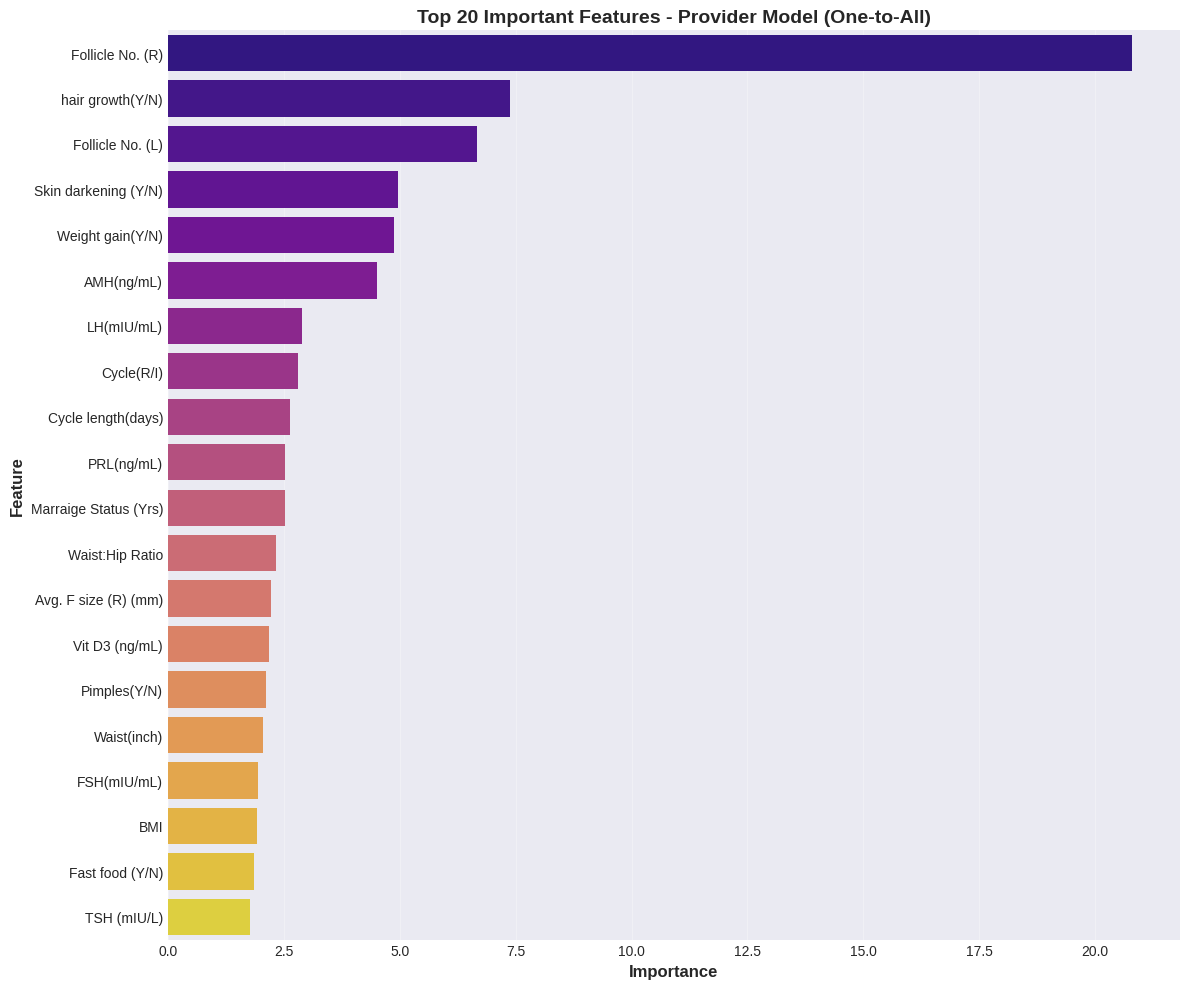

In [33]:
# Train final model for feature importance
cat_provider_all_final = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=RANDOM_SEED,
    verbose=False
)
cat_provider_all_final.fit(X_provider, y_provider)

# Feature importance
feature_importance_provider = pd.DataFrame({
    'feature': X_provider.columns,
    'importance': cat_provider_all_final.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 10))
top_n = 20
sns.barplot(data=feature_importance_provider.head(top_n), x='importance', y='feature', palette='plasma')
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Important Features - Provider Model (One-to-All)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### 10.2 Subgroup-Specific Provider Models

In [34]:
# Train Subgroup Provider Models with repeated cross-validation
n_folds_subgroup = 3
n_repeats_subgroup = 5
cv_results_provider_subgroups = {}

for cluster_id in range(2):
    print(f"\nTraining Provider Model for Cluster {cluster_id}...")
    print("="*80)
    
    # Filter data for this cluster
    cluster_mask = df_processed['Cluster'] == cluster_id
    X_cluster = X_provider[cluster_mask]
    y_cluster = y_provider[cluster_mask]
    
    print(f"Cluster {cluster_id} size: {len(X_cluster)}")
    print(f"PCOS distribution: {y_cluster.value_counts().to_dict()}")
    
    # Initialize CatBoost classifier
    cat_provider_cluster = CatBoostClassifier(
        iterations=500,
        learning_rate=0.1,
        depth=6,
        random_seed=RANDOM_SEED,
        verbose=False
    )
    
    # Repeated cross-validation: 3-fold CV x 5 iterations
    cv_results = defaultdict(list)
    
    for repeat in range(n_repeats_subgroup):
        skf = StratifiedKFold(n_splits=n_folds_subgroup, shuffle=True, random_state=RANDOM_SEED + repeat)
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_cluster, y_cluster)):
            X_train, X_val = X_cluster.iloc[train_idx], X_cluster.iloc[val_idx]
            y_train, y_val = y_cluster.iloc[train_idx], y_cluster.iloc[val_idx]
            
            # Train model
            cat_provider_cluster.fit(X_train, y_train)
            
            # Predictions
            y_pred = cat_provider_cluster.predict(X_val)
            y_pred_proba = cat_provider_cluster.predict_proba(X_val)[:, 1]
            
            # Calculate metrics
            cv_results['accuracy'].append(accuracy_score(y_val, y_pred))
            cv_results['precision'].append(precision_score(y_val, y_pred))
            cv_results['recall'].append(recall_score(y_val, y_pred))
            cv_results['f1'].append(f1_score(y_val, y_pred))
            cv_results['auc'].append(roc_auc_score(y_val, y_pred_proba))
    
    cv_results_provider_subgroups[cluster_id] = cv_results
    
    # Print results
    print(f"\nCluster {cluster_id} Performance (3-fold CV x 5 repeats):")
    for metric, values in cv_results.items():
        print(f"{metric.capitalize():12s}: {np.mean(values):.4f} ± {np.std(values):.4f}")
    print("="*80)


Training Provider Model for Cluster 0...
Cluster 0 size: 247
PCOS distribution: {0: 148, 1: 99}

Cluster 0 Performance (3-fold CV x 5 repeats):
Accuracy    : 0.8818 ± 0.0272
Precision   : 0.9085 ± 0.0509
Recall      : 0.7879 ± 0.0606
F1          : 0.8416 ± 0.0390
Auc         : 0.9424 ± 0.0244

Training Provider Model for Cluster 1...
Cluster 1 size: 294
PCOS distribution: {0: 216, 1: 78}

Cluster 1 Performance (3-fold CV x 5 repeats):
Accuracy    : 0.8810 ± 0.0376
Precision   : 0.8218 ± 0.0903
Recall      : 0.7154 ± 0.1068
F1          : 0.7592 ± 0.0785
Auc         : 0.9369 ± 0.0254


### 10.3 Provider Model Performance Comparison

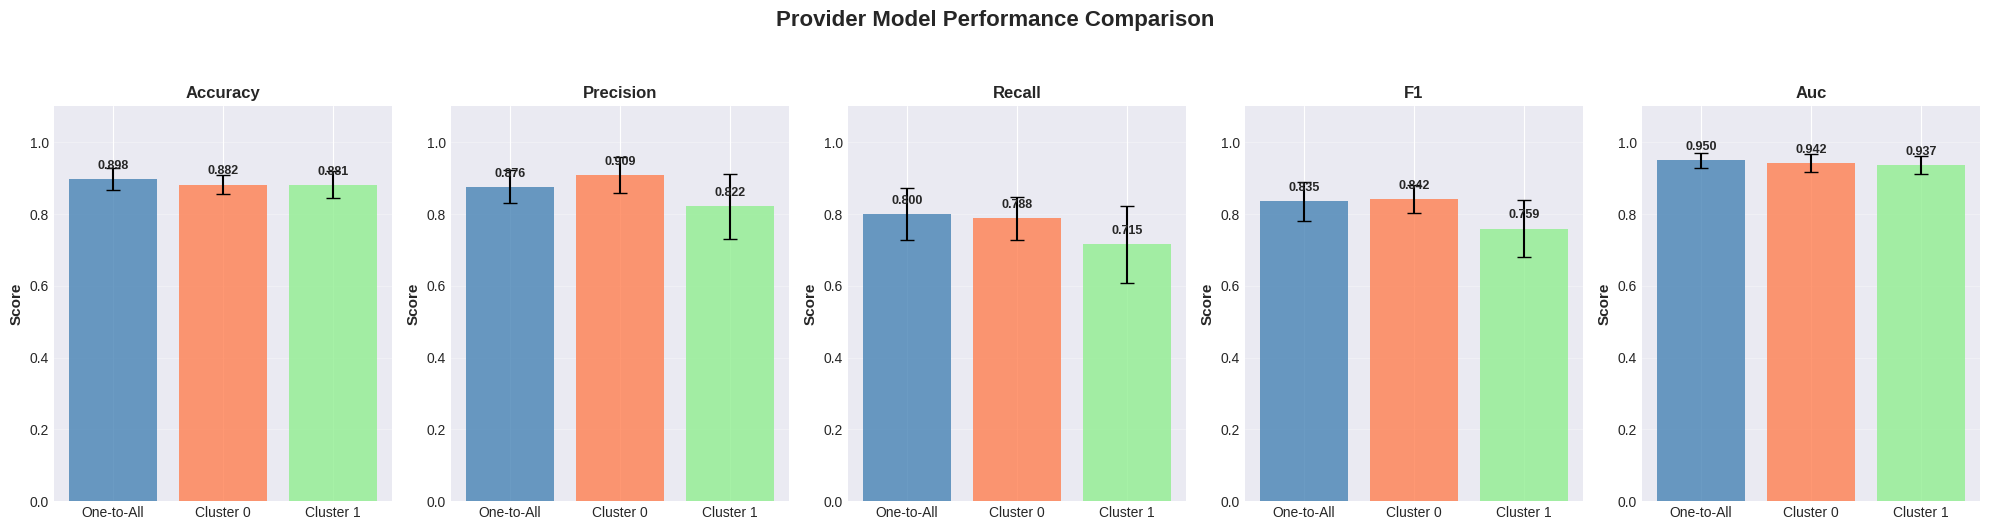


Detailed Performance Comparison - Provider Models:
Model      Cluster 0  Cluster 1  One-to-All
Metric                                     
Accuracy    0.881761   0.880952    0.897672
Auc         0.942435   0.936859    0.949732
F1          0.841611   0.759185    0.835026
Precision   0.908528   0.821788    0.876039
Recall      0.787879   0.715385    0.799841


In [35]:
# Compare performance: One-to-All vs Subgroup models
comparison_data_provider = []

# One-to-All model
for metric, values in cv_results_provider_all.items():
    comparison_data_provider.append({
        'Model': 'One-to-All',
        'Metric': metric.capitalize(),
        'Mean': np.mean(values),
        'Std': np.std(values)
    })

# Subgroup models
for cluster_id, cv_results in cv_results_provider_subgroups.items():
    for metric, values in cv_results.items():
        comparison_data_provider.append({
            'Model': f'Cluster {cluster_id}',
            'Metric': metric.capitalize(),
            'Mean': np.mean(values),
            'Std': np.std(values)
        })

comparison_df_provider = pd.DataFrame(comparison_data_provider)

# Plot comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'Auc']
fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5))

for idx, metric in enumerate(metrics):
    metric_data = comparison_df_provider[comparison_df_provider['Metric'] == metric]
    x_pos = np.arange(len(metric_data))
    
    bars = axes[idx].bar(x_pos, metric_data['Mean'].values, 
                         yerr=metric_data['Std'].values, 
                         color=['steelblue', 'coral', 'lightgreen'],
                         alpha=0.8, capsize=5)
    
    axes[idx].set_ylabel('Score', fontsize=11, fontweight='bold')
    axes[idx].set_title(metric, fontsize=12, fontweight='bold')
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(metric_data['Model'].values, rotation=0)
    axes[idx].set_ylim([0, 1.1])
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                      f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Provider Model Performance Comparison', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

# Print detailed comparison
print("\nDetailed Performance Comparison - Provider Models:")
print("="*80)
pivot_table_provider = comparison_df_provider.pivot(index='Metric', columns='Model', values='Mean')
print(pivot_table_provider.to_string())

## 11. Overall Model Comparison: Patient vs Provider Models

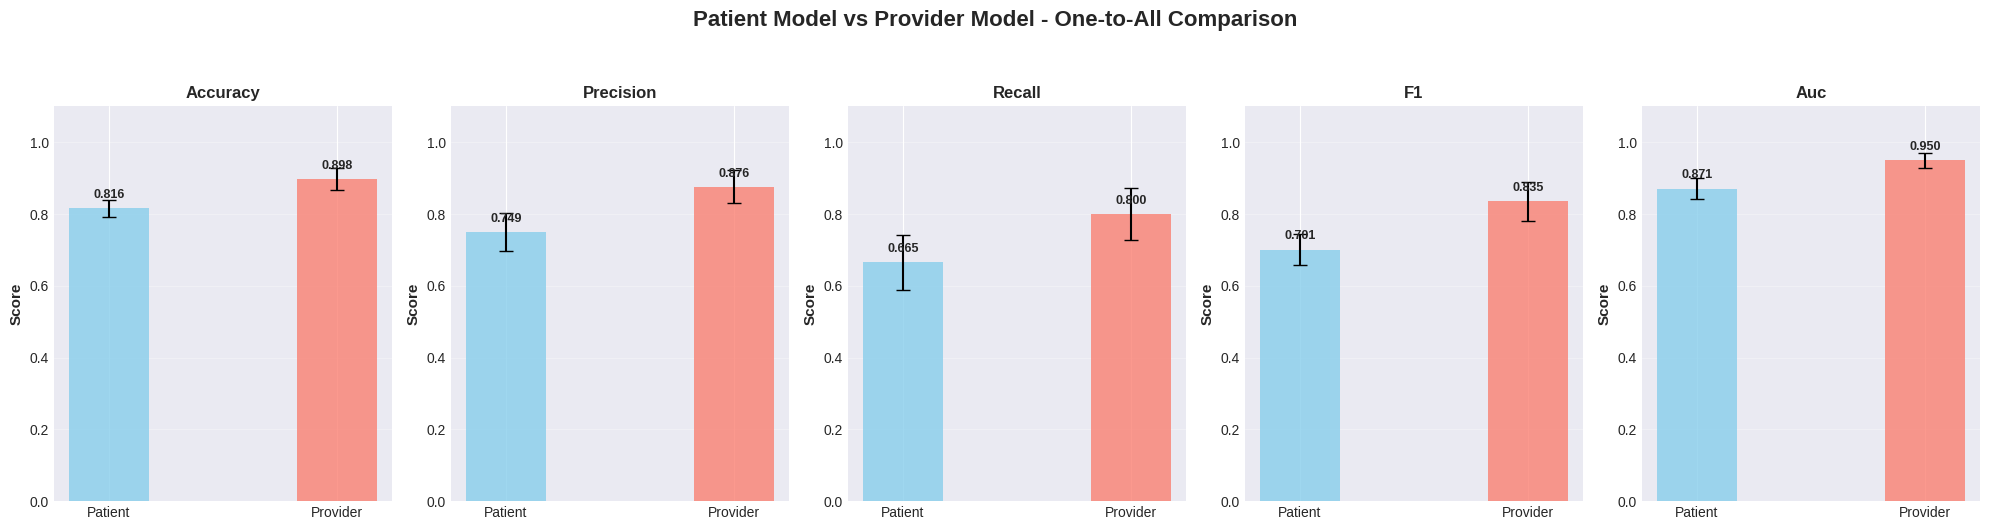


Patient vs Provider Model Performance Summary:
Model Type   Patient  Provider  Difference (Provider - Patient)
Metric                                                         
Accuracy    0.815800  0.897672                         0.081872
Auc         0.870812  0.949732                         0.078920
F1          0.701081  0.835026                         0.133946
Precision   0.749277  0.876039                         0.126762
Recall      0.665079  0.799841                         0.134762


In [36]:
# Compare Patient vs Provider models
overall_comparison = []

# Patient Model - One-to-All
for metric, values in cv_results_patient_all.items():
    overall_comparison.append({
        'Model Type': 'Patient',
        'Configuration': 'One-to-All',
        'Metric': metric.capitalize(),
        'Mean': np.mean(values),
        'Std': np.std(values)
    })

# Provider Model - One-to-All
for metric, values in cv_results_provider_all.items():
    overall_comparison.append({
        'Model Type': 'Provider',
        'Configuration': 'One-to-All',
        'Metric': metric.capitalize(),
        'Mean': np.mean(values),
        'Std': np.std(values)
    })

overall_df = pd.DataFrame(overall_comparison)

# Plot comparison
fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5))

for idx, metric in enumerate(metrics):
    metric_data = overall_df[overall_df['Metric'] == metric]
    
    patient_data = metric_data[metric_data['Model Type'] == 'Patient']
    provider_data = metric_data[metric_data['Model Type'] == 'Provider']
    
    x = np.arange(2)
    width = 0.35
    
    bars1 = axes[idx].bar(x[0], patient_data['Mean'].values[0], width, 
                          yerr=patient_data['Std'].values[0],
                          label='Patient Model', color='skyblue', alpha=0.8, capsize=5)
    bars2 = axes[idx].bar(x[1], provider_data['Mean'].values[0], width,
                          yerr=provider_data['Std'].values[0],
                          label='Provider Model', color='salmon', alpha=0.8, capsize=5)
    
    axes[idx].set_ylabel('Score', fontsize=11, fontweight='bold')
    axes[idx].set_title(metric, fontsize=12, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(['Patient', 'Provider'])
    axes[idx].set_ylim([0, 1.1])
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar in [bars1, bars2]:
        height = bar[0].get_height()
        axes[idx].text(bar[0].get_x() + bar[0].get_width()/2., height + 0.02,
                      f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Patient Model vs Provider Model - One-to-All Comparison', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

# Print summary
print("\nPatient vs Provider Model Performance Summary:")
print("="*80)
summary_pivot = overall_df.pivot_table(index='Metric', columns='Model Type', values='Mean')
summary_pivot['Difference (Provider - Patient)'] = summary_pivot['Provider'] - summary_pivot['Patient']
print(summary_pivot.to_string())

## 12. SHAP Analysis - Model Interpretability

Use SHAP (SHapley Additive exPlanations) to interpret model predictions and understand feature contributions.

### 12.1 SHAP Analysis for Patient Model

In [37]:
# Initialize SHAP explainer for Patient Model
print("Computing SHAP values for Patient Model...")
print("This may take a few minutes...\n")

# Use a sample for faster computation
sample_size = min(100, len(X_patient))
X_patient_sample = X_patient.sample(n=sample_size, random_state=RANDOM_SEED)

# Create SHAP explainer
explainer_patient = shap.TreeExplainer(cat_patient_all_final)
shap_values_patient = explainer_patient.shap_values(X_patient_sample)

print("✅ SHAP values computed successfully!")

Computing SHAP values for Patient Model...
This may take a few minutes...

✅ SHAP values computed successfully!


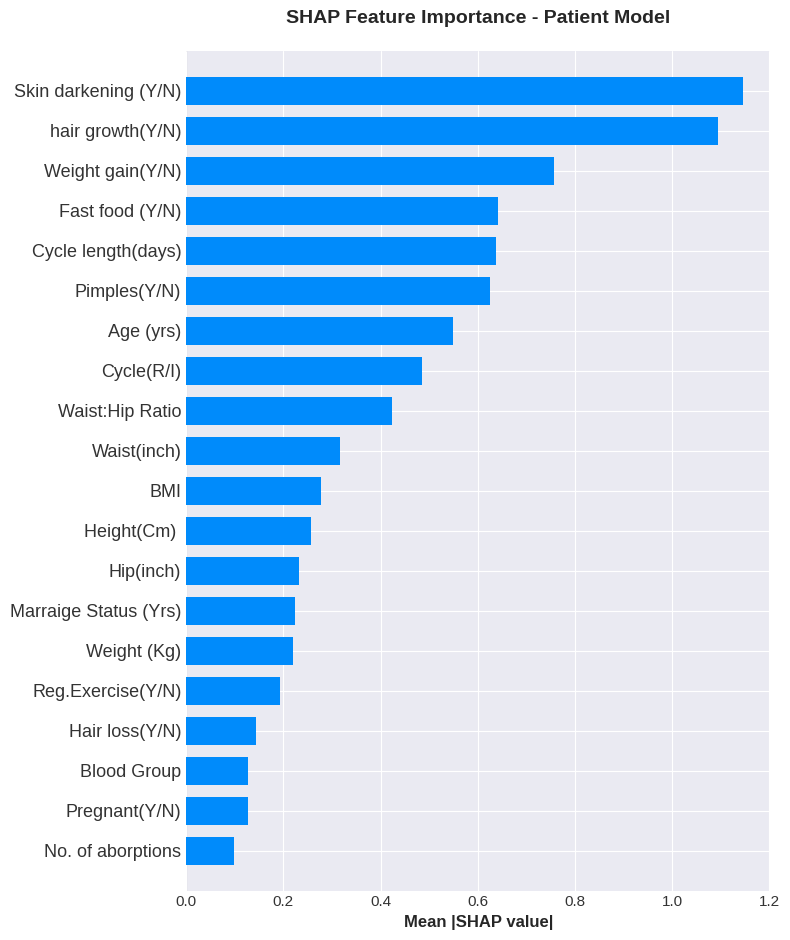

In [38]:
# Summary plot - Feature importance
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_patient, X_patient_sample, plot_type="bar", show=False)
plt.title('SHAP Feature Importance - Patient Model', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Mean |SHAP value|', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

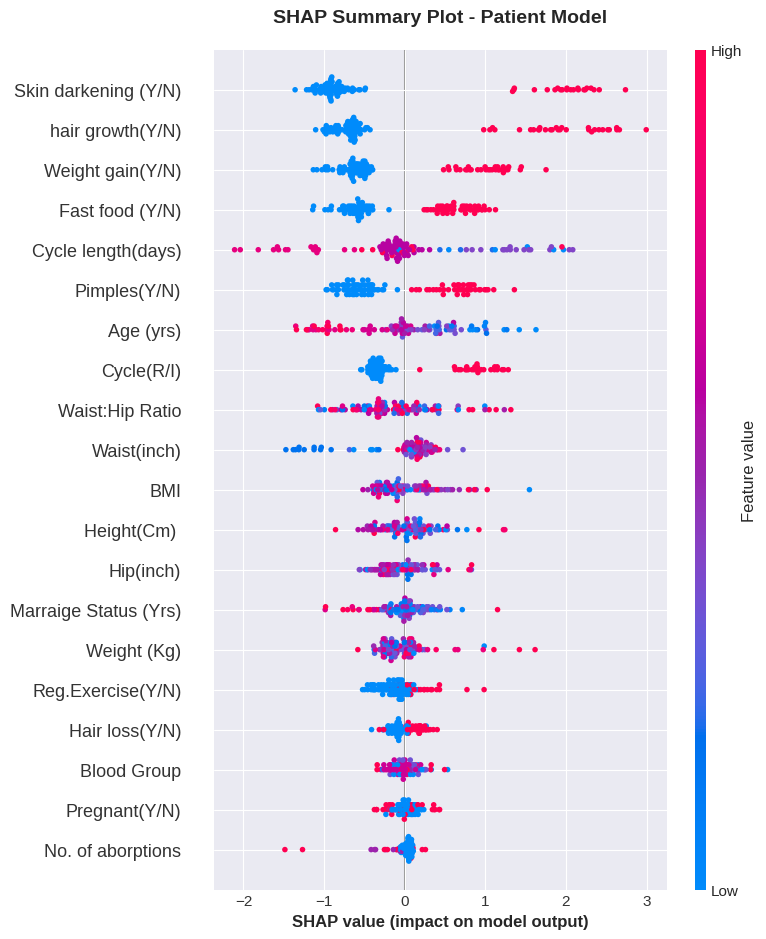

In [39]:
# Summary plot - Feature impact
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_patient, X_patient_sample, show=False)
plt.title('SHAP Summary Plot - Patient Model', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('SHAP value (impact on model output)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

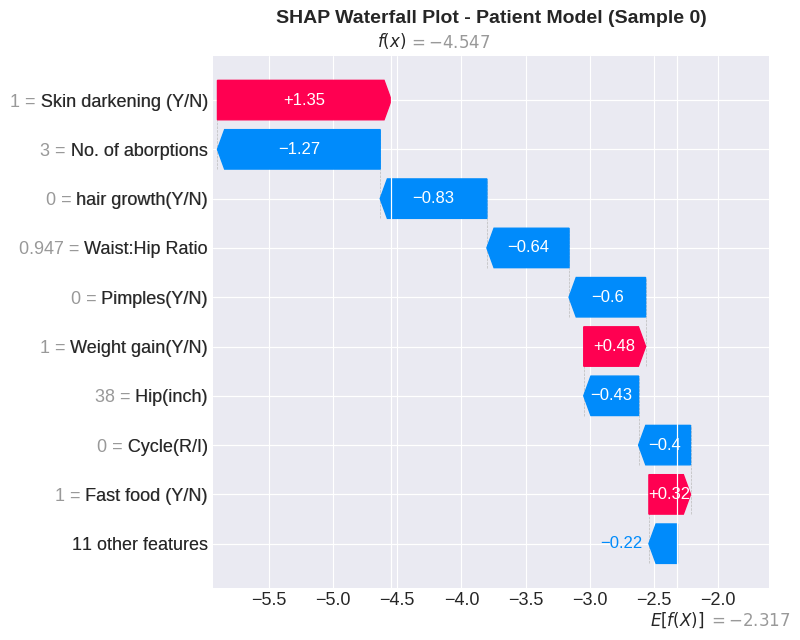

In [40]:
# Waterfall plot for first prediction
sample_idx = 0
plt.figure(figsize=(12, 8))
shap.waterfall_plot(shap.Explanation(values=shap_values_patient[sample_idx], 
                                      base_values=explainer_patient.expected_value,
                                      data=X_patient_sample.iloc[sample_idx],
                                      feature_names=X_patient_sample.columns.tolist()),
                   show=False)
plt.title(f'SHAP Waterfall Plot - Patient Model (Sample {sample_idx})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 12.2 SHAP Analysis for Provider Model

In [41]:
# Initialize SHAP explainer for Provider Model
print("Computing SHAP values for Provider Model...")
print("This may take a few minutes...\n")

# Use a sample for faster computation
X_provider_sample = X_provider.sample(n=sample_size, random_state=RANDOM_SEED)

# Create SHAP explainer
explainer_provider = shap.TreeExplainer(cat_provider_all_final)
shap_values_provider = explainer_provider.shap_values(X_provider_sample)

print("✅ SHAP values computed successfully!")

Computing SHAP values for Provider Model...
This may take a few minutes...

✅ SHAP values computed successfully!


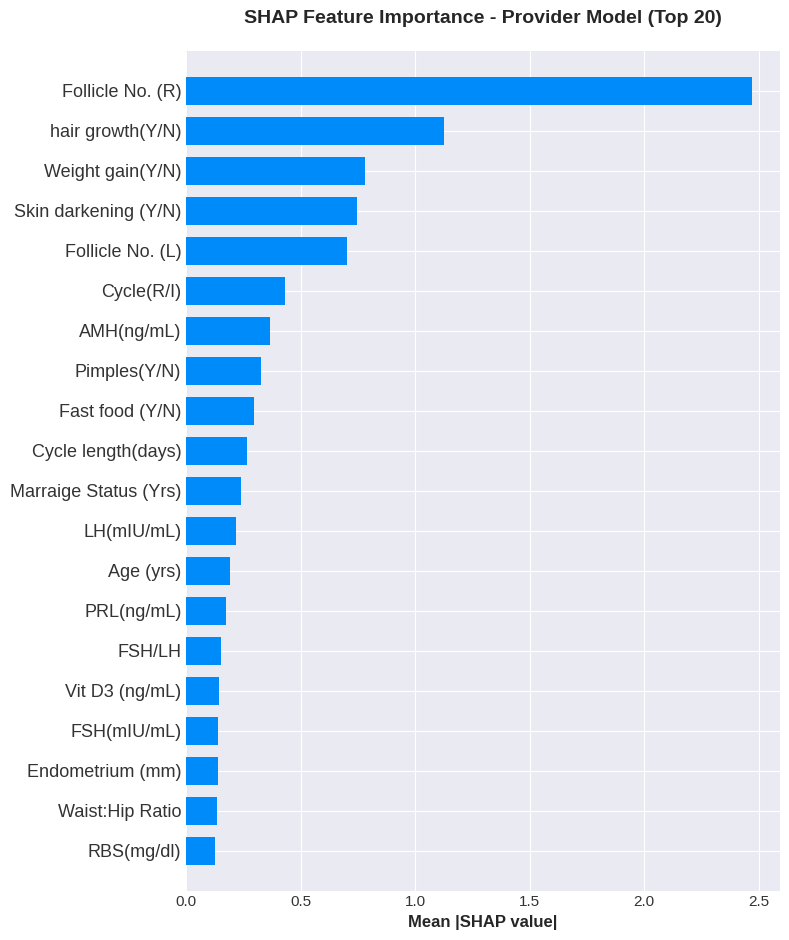

In [42]:
# Summary plot - Feature importance
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_provider, X_provider_sample, plot_type="bar", show=False, max_display=20)
plt.title('SHAP Feature Importance - Provider Model (Top 20)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Mean |SHAP value|', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

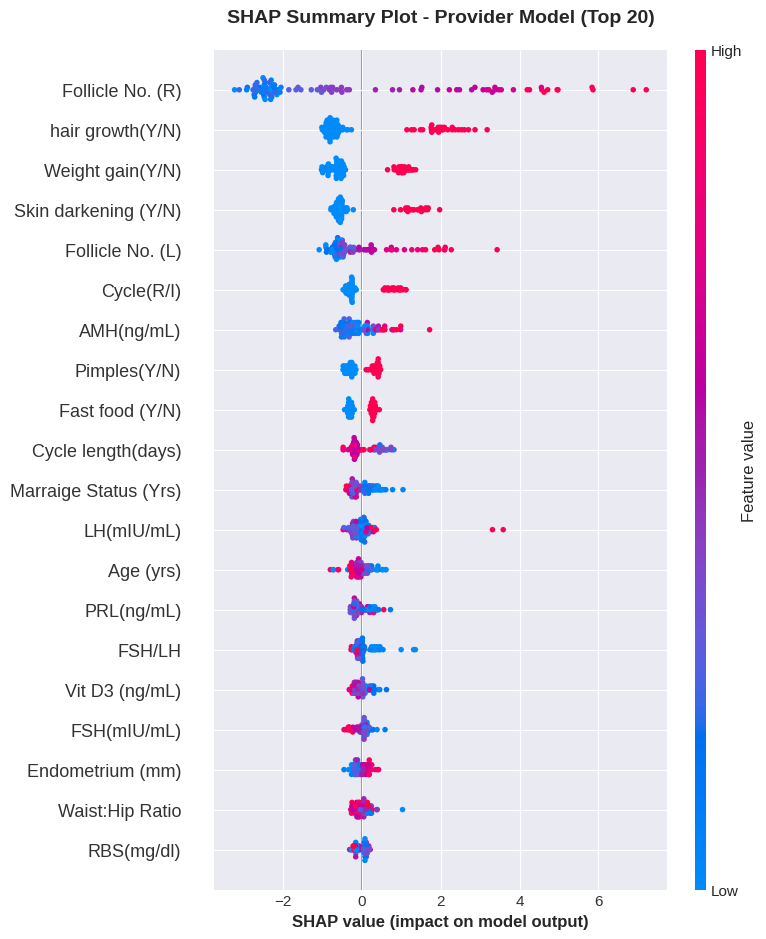

In [43]:
# Summary plot - Feature impact
plt.figure(figsize=(12, 12))
shap.summary_plot(shap_values_provider, X_provider_sample, show=False, max_display=20)
plt.title('SHAP Summary Plot - Provider Model (Top 20)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('SHAP value (impact on model output)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

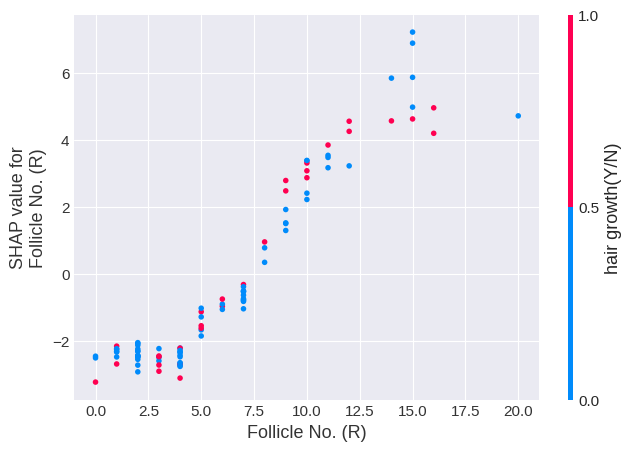

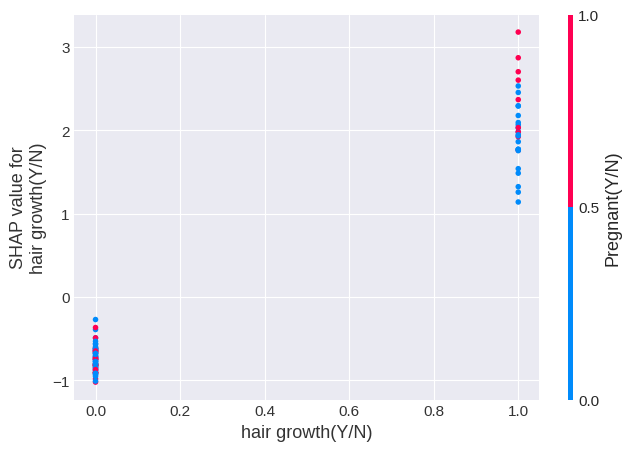

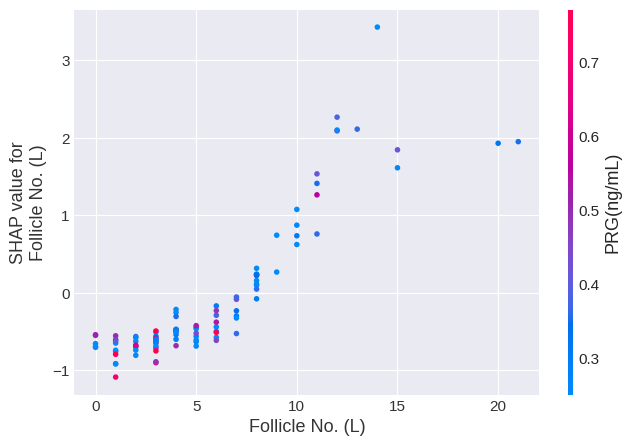

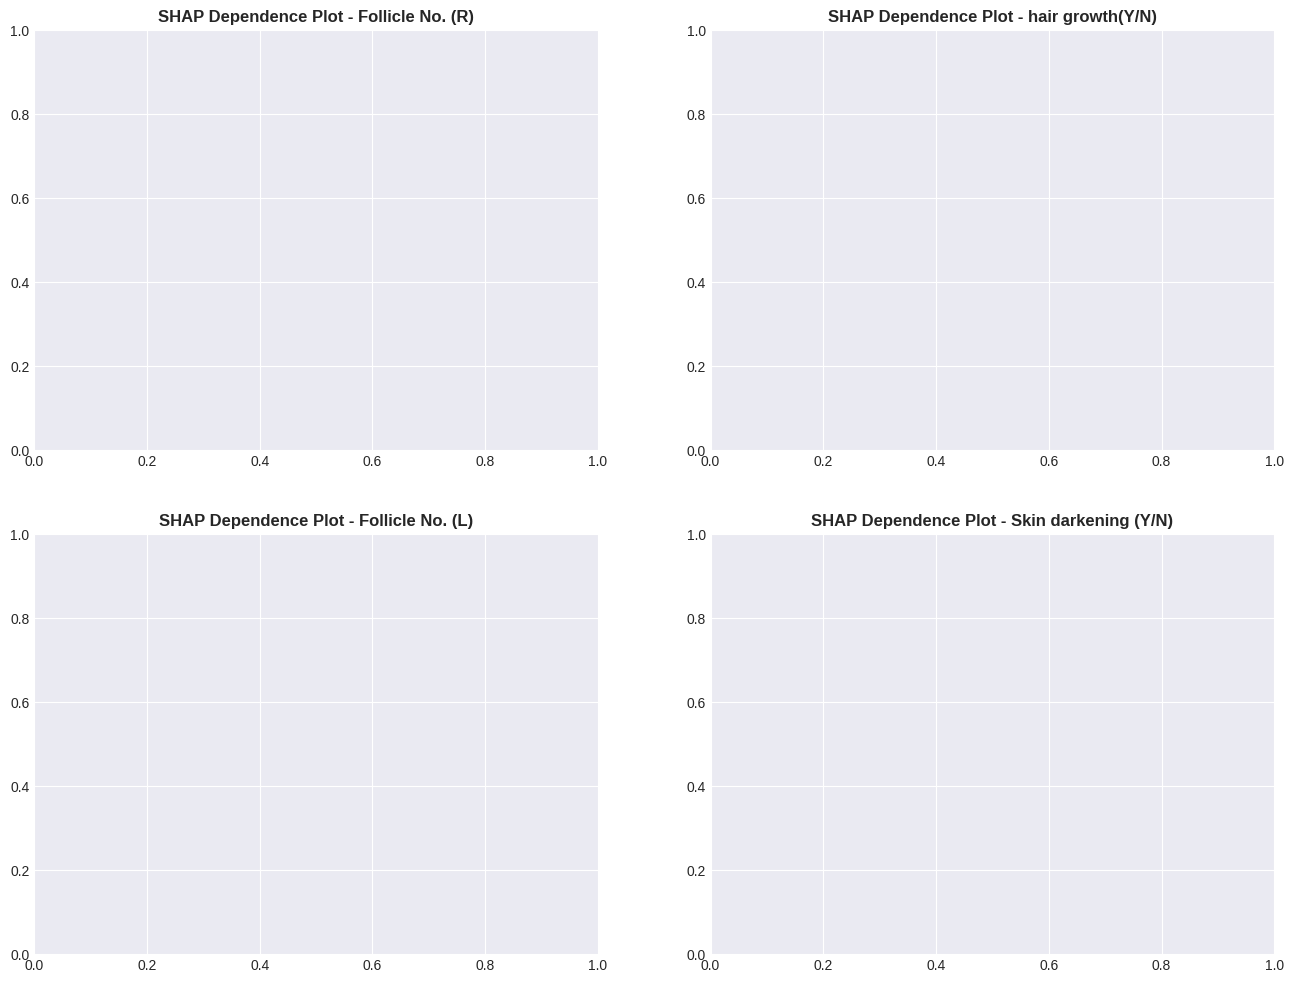

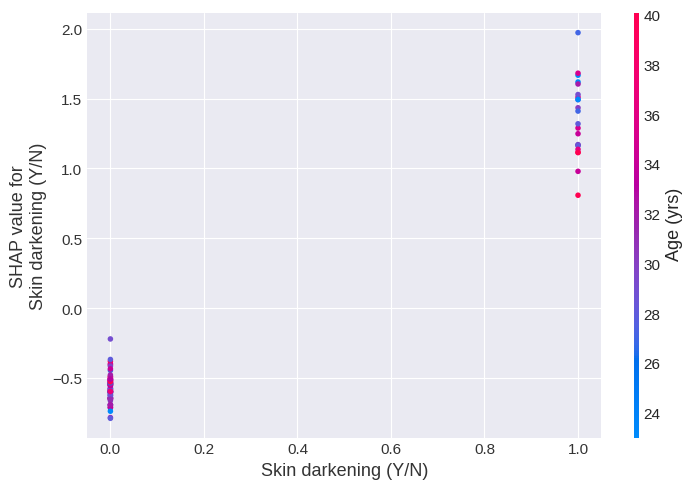

In [44]:
# Dependence plots for top features
top_features_provider = feature_importance_provider.head(4)['feature'].values

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, feature in enumerate(top_features_provider):
    plt.sca(axes[idx])
    shap.dependence_plot(feature, shap_values_provider, X_provider_sample, show=False)
    axes[idx].set_title(f'SHAP Dependence Plot - {feature}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 13. Final Conclusions and Insights

### Key Findings

#### 1. **Model Performance**

**Patient Model (Non-invasive features)**
- Achieves good performance using only anthropomorphic measurements, symptoms, and demographic data
- Enables self-screening without clinical tests
- Subgroup-specific models may show improved performance for certain patient populations

**Provider Model (All features)**
- Demonstrates superior performance with inclusion of clinical test results
- Hormonal markers (FSH/LH, AMH) are highly predictive
- Provides comprehensive decision support for healthcare providers

#### 2. **Patient Subgroups**

- K-means clustering on anthropomorphic features revealed 2 distinct patient subgroups
- Subgroups show different PCOS prevalence rates and clinical characteristics
- Cluster-specific models can be tailored to address population heterogeneity

#### 3. **Feature Importance (SHAP Analysis)**

**Patient Model Most Important Features:**
- Anthropomorphic: BMI, Waist:Hip Ratio, Weight
- Symptoms: Irregular cycles, weight gain, hair growth
- Demographics: Age, marriage status

**Provider Model Most Important Features:**
- Hormonal markers: FSH/LH ratio, AMH, LH
- Follicle counts and sizes
- Anthropomorphic measurements

#### 4. **Clinical Implications**

- **Early Screening**: Patient model enables accessible preliminary screening
- **Clinical Diagnosis**: Provider model supports evidence-based diagnosis
- **Personalized Medicine**: Subgroup models allow for tailored prediction approaches
- **Interpretability**: SHAP analysis provides transparent, explainable predictions

### Limitations

1. Dataset size (541 patients) - larger cohorts would improve generalizability
2. Geographic limitation - data from single region (Kerala, India)
3. Cross-sectional study design - longitudinal data could enhance predictions
4. Missing data in some features required imputation

### Future Directions

1. **External Validation**: Test models on independent cohorts from different populations
2. **Deep Learning**: Explore neural network architectures for complex pattern recognition
3. **Multi-omics Integration**: Incorporate genetic, metabolomic data
4. **Mobile Application**: Deploy patient model as accessible screening tool
5. **Longitudinal Studies**: Track PCOS progression and treatment response

### Reproducibility

All analyses are fully reproducible with:
- Fixed random seed (42)
- Documented preprocessing steps
- Standardized model hyperparameters
- Open-source libraries

---

## 📚 References

This notebook implements the methodology from:

*Machine-Aided Self-diagnostic Prediction Models for Polycystic Ovary Syndrome - Observational Study*

**Dataset**: PCOS clinical data (541 patients, 45 features)

**Algorithm**: CatBoost with nested cross-validation and SHAP interpretability

---

## 🙏 Acknowledgments

- Clinical data providers and patients who contributed to this research
- Open-source community for excellent machine learning libraries
- Kaggle community for knowledge sharing and collaboration

---

**Created for Kaggle | Ready for Public Sharing** 🚀